In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from matplotlib.backends.backend_pdf import PdfPages

from matplotlib.lines import Line2D
import matplotlib.colors as colors

from scipy.stats import gaussian_kde
from scipy.stats import mode
import seaborn as sns
from sklearn.neighbors import KernelDensity

import itertools

from funcs_v2 import get_z, get_SNR, get_dmean, get_meta
from spline_fit_v2 import spline_fit

import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def func(z):
    def func2(x):
        return x*(1+z)
    return func2

def inv(z):
    def inv2(x):
        return x/(1+z)
    return inv2

In [2]:
hpath = '/media/bartosz/USB STICK/added_sample_XIE/'
hspath = hpath + 'added_sample_XIE/'
hfpath = hpath + 'fits/'
hnpath = hpath + 'normed/'

hmeta_file = np.loadtxt(hpath + 'notes', dtype='str')

hnames = hmeta_file[:,0]
hz = [float(z) for z in hmeta_file[:,1]]

In [3]:
w1l = 13450     # water absorption observed WL
w1r = 14250
w2l = 18200
w2r = 19400

Q4


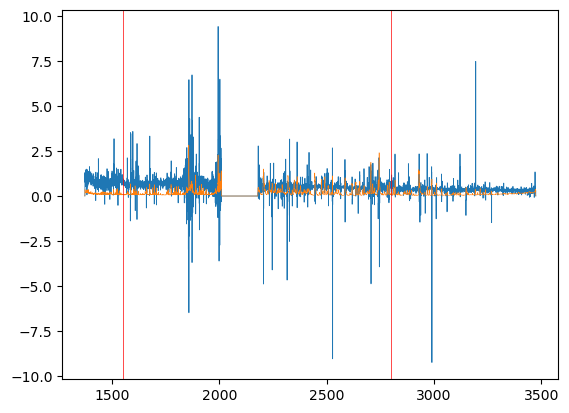

Q5


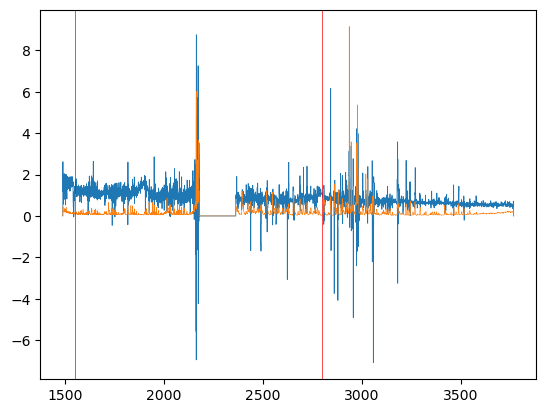

Q6


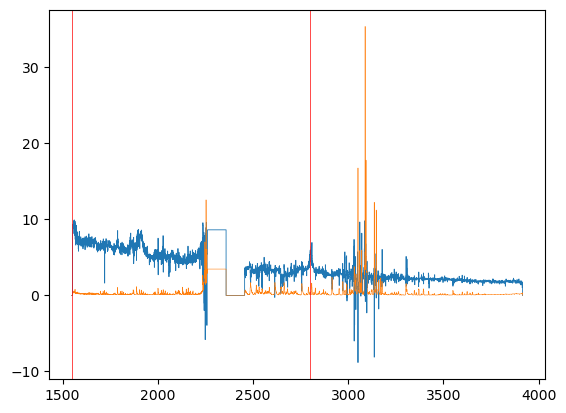

Q7


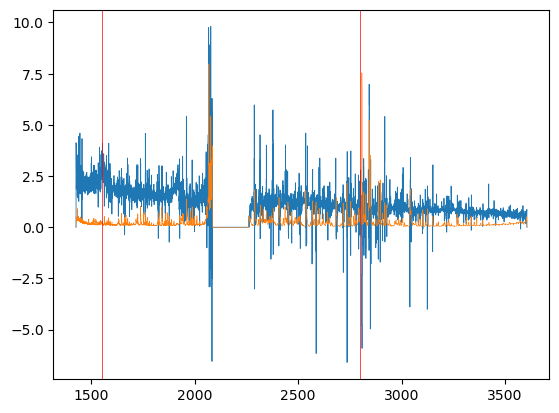

Q8


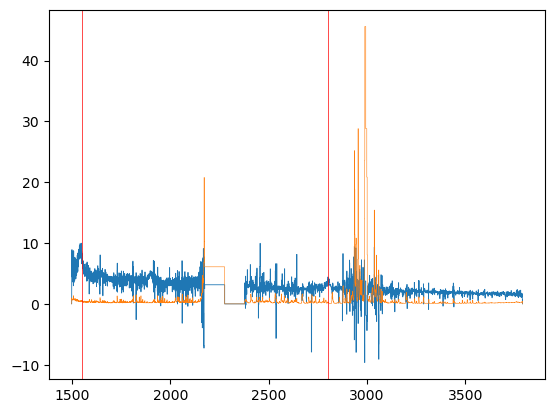

Q9


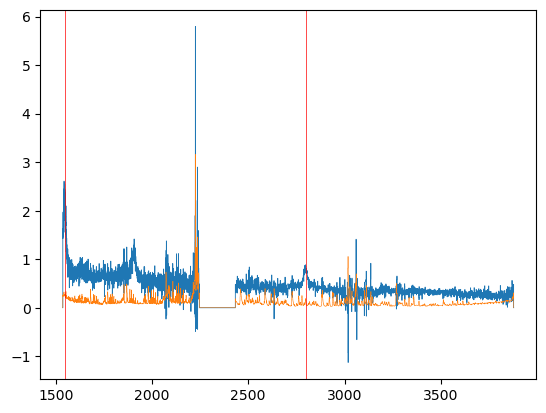

Q10


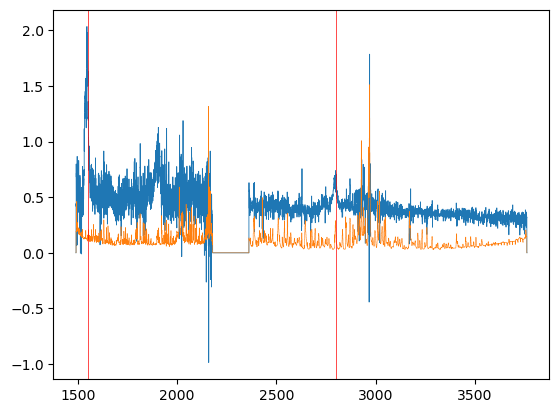

Q11


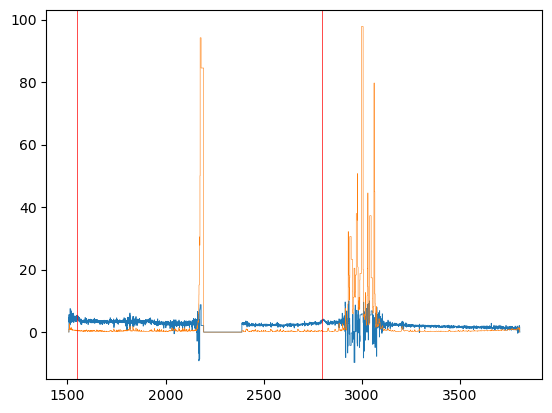

Q12


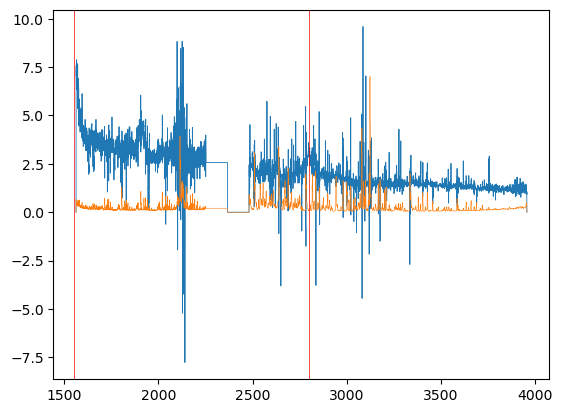

Q13


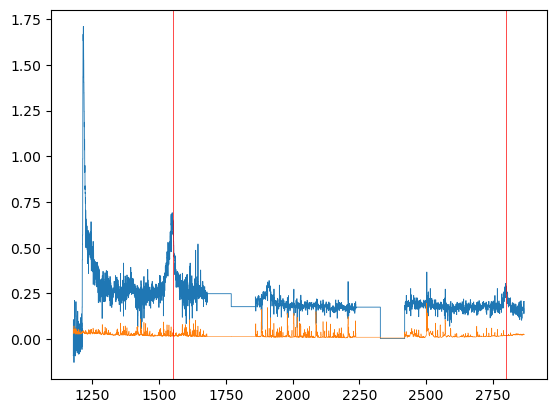

In [6]:
for i,qname in enumerate(hnames):
    print(qname)

    #pp = PdfPages('plots/{}_dc.pdf'.format(qname))
    fname = qname + '.csv'
    z_in = hz[i]
    w1l_r,w1r_r = w1l/(1+z_in),w1r/(1+z_in)

    # load spectrum
    spec = np.loadtxt(hspath + fname,delimiter=',',skiprows=1)
    wl, flux, sig = spec[:,0], spec[:,1], spec[:,2]
    mask_ini = abs(flux) < 10
    wl, flux, sig = wl[mask_ini]/(1+z_in), flux[mask_ini], sig[mask_ini]

    # # mask both water absorption ranges
    # mask1 = np.logical_or(wl<w1l,wl>w1r)
    # mask2 = np.logical_or(wl<w2l,wl>w2r)
    # mask3 = np.logical_and(mask1,mask2)
    # wl = wl[mask3]
    # flux = flux[mask3]
    # sig = sig[mask3]

    # # stddev and mean of errors
    # err_threshold = 2    #5*10**(-17)                   # add error threshold to mask values with very large systematic errors
    # sig_std = np.std(sig[sig<err_threshold])
    # sig_mean = np.mean(sig[sig<err_threshold])


    # # mean of flux
    # flux_median = np.median(flux[sig<err_threshold])
    
    # # mask errors larger than 2 sigma and flux values close to zero
    # mask = np.logical_and( sig <= sig_mean+2*sig_std, flux >= 0.0*flux_median )
    
    
    # # Apply mask to wavelength and flux arrays
    # masked_wl = wl[mask]
    # masked_flux = flux[mask]
    # masked_sig = sig[mask]    

    plt.plot(wl,flux,drawstyle='steps-mid',lw=0.6)
    plt.plot(wl,sig,drawstyle='steps-mid',lw=0.4)
    
    # plt.plot(masked_wl,masked_flux,drawstyle='steps-mid',lw=0.6)
    # plt.plot(masked_wl,masked_sig,drawstyle='steps-mid',lw=0.4)
    #plt.axhline(1)
    #plt.axvline(1800,c='green',lw=0.5)
    plt.axvline(1550,c='red',lw=0.5)
    plt.axvline(2800,c='red',lw=0.5)
    plt.show()
    plt.close()

Q4


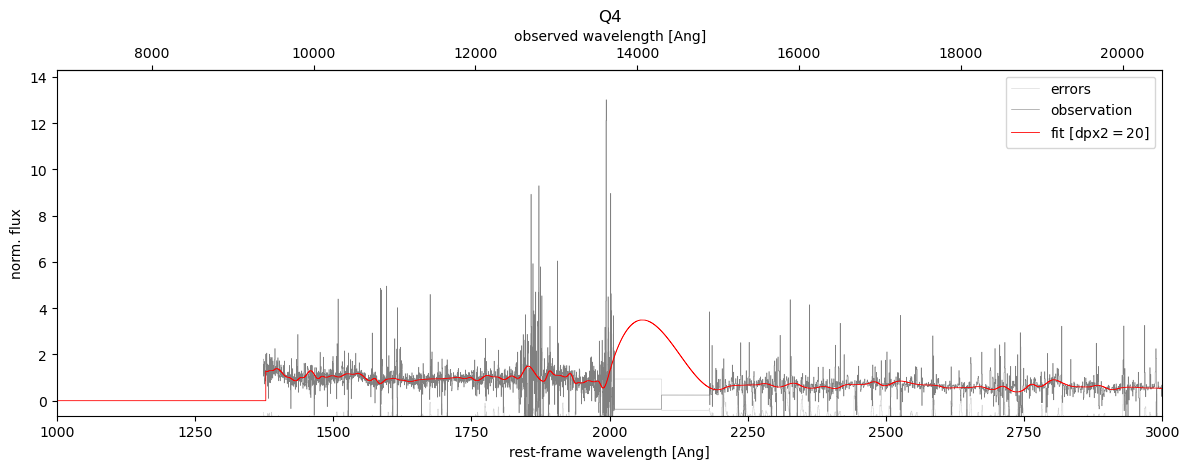

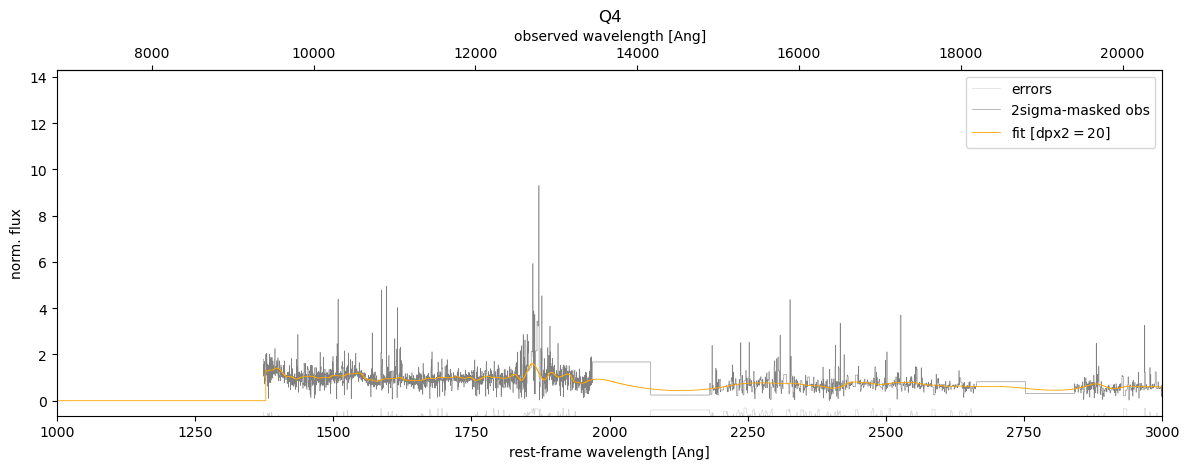

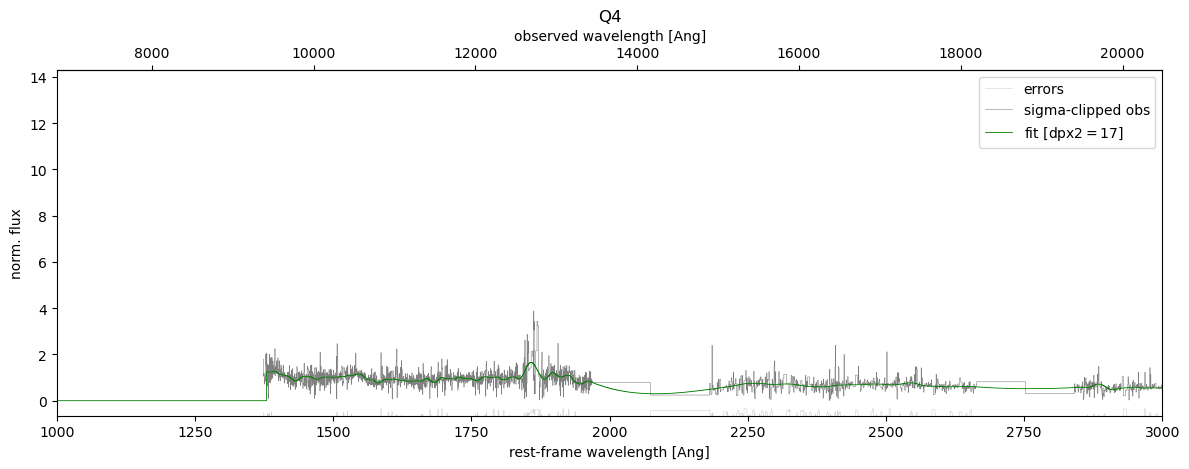

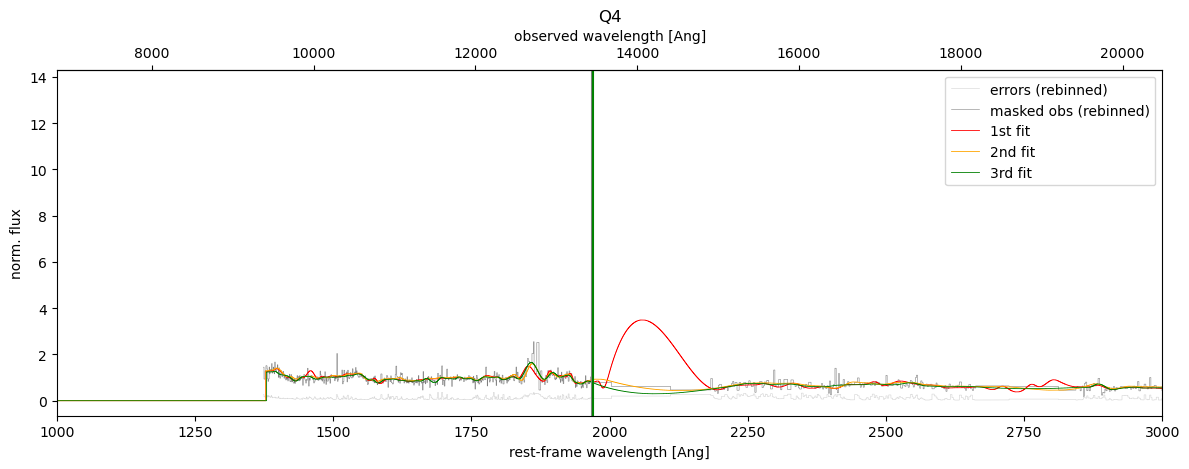

Q5


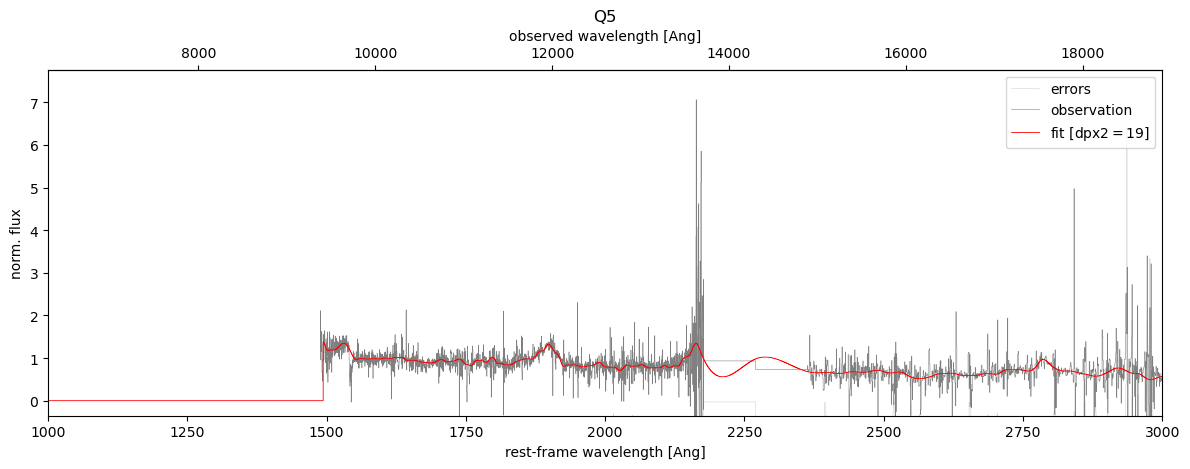

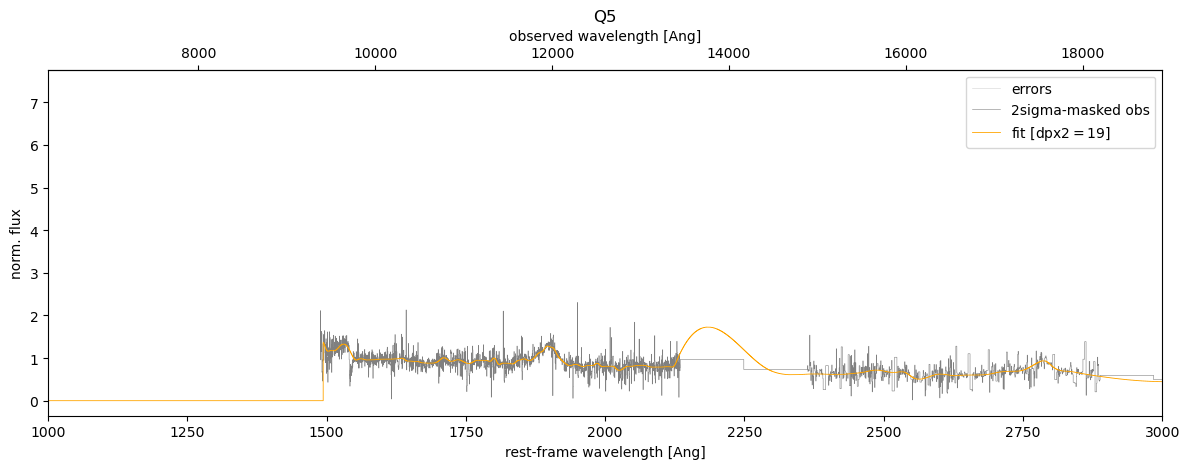

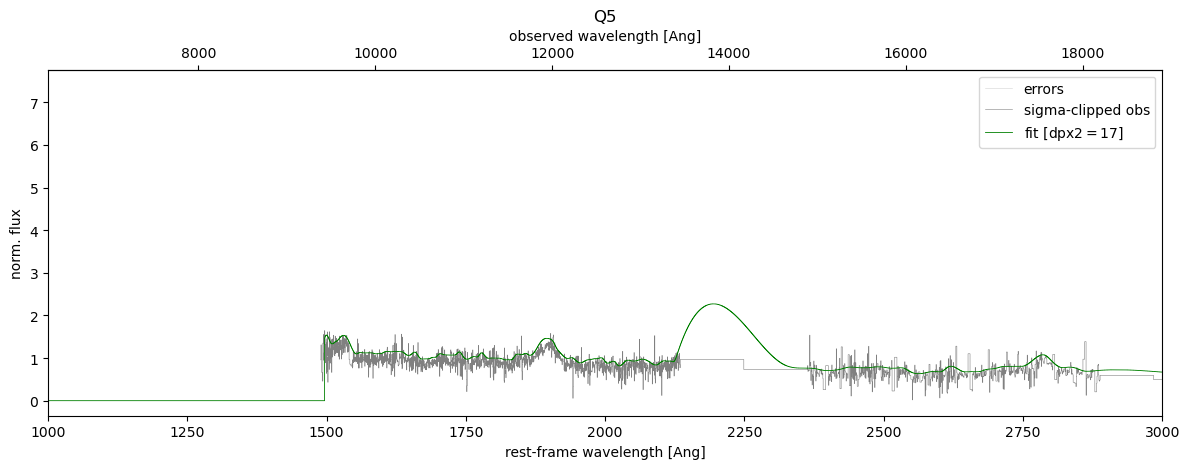

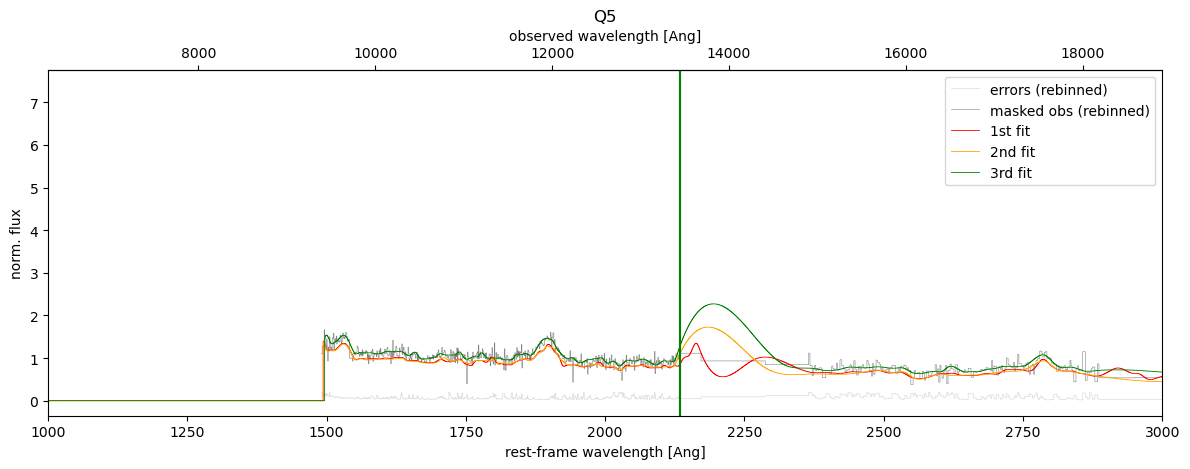

Q6


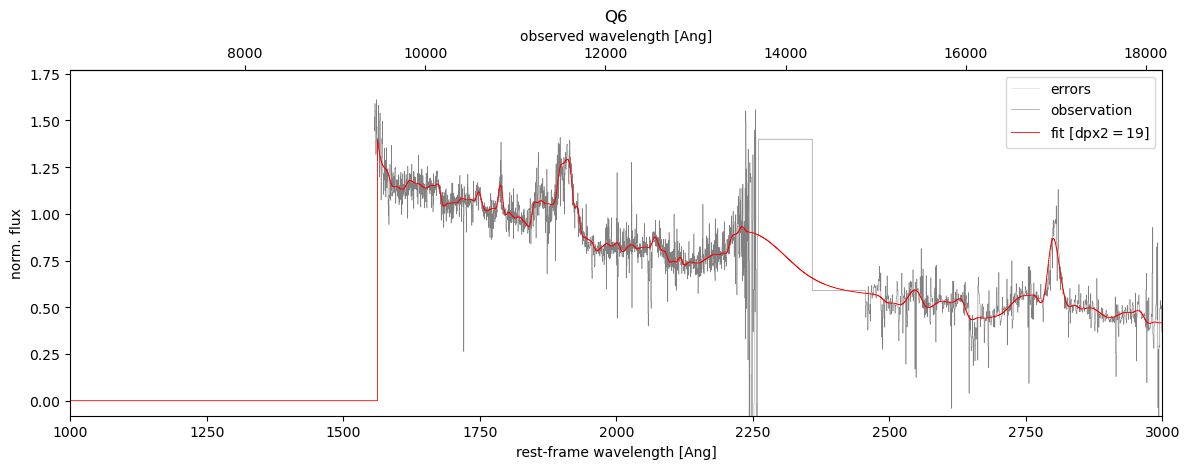

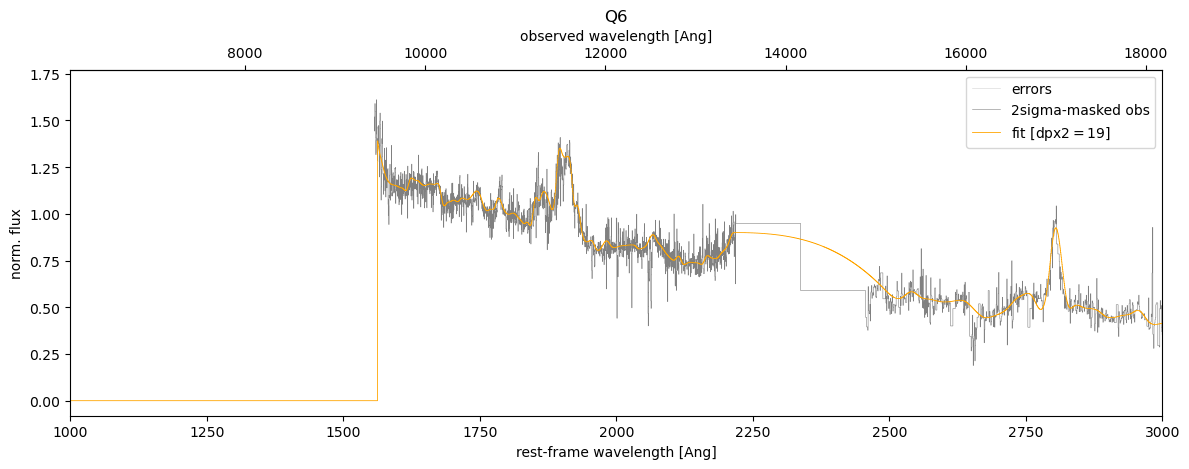

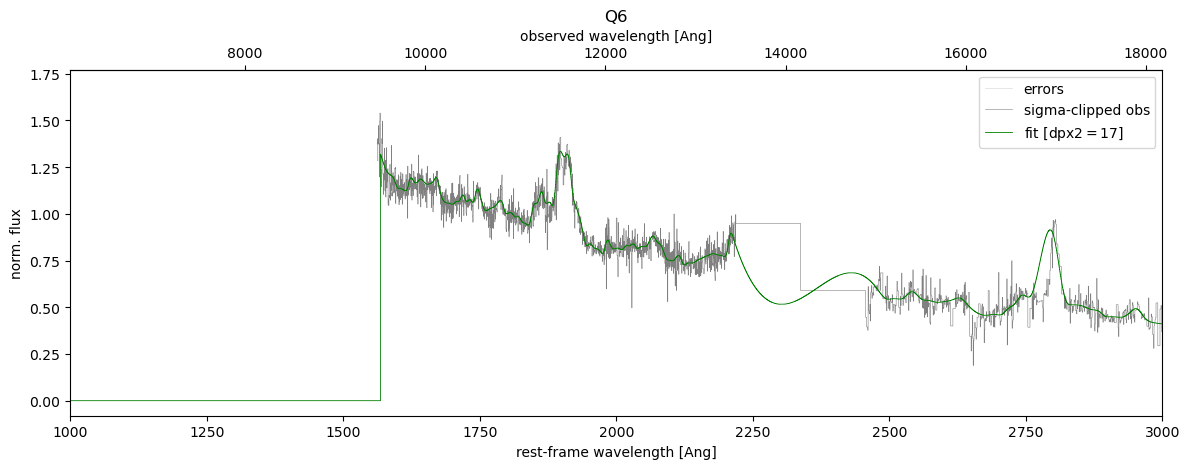

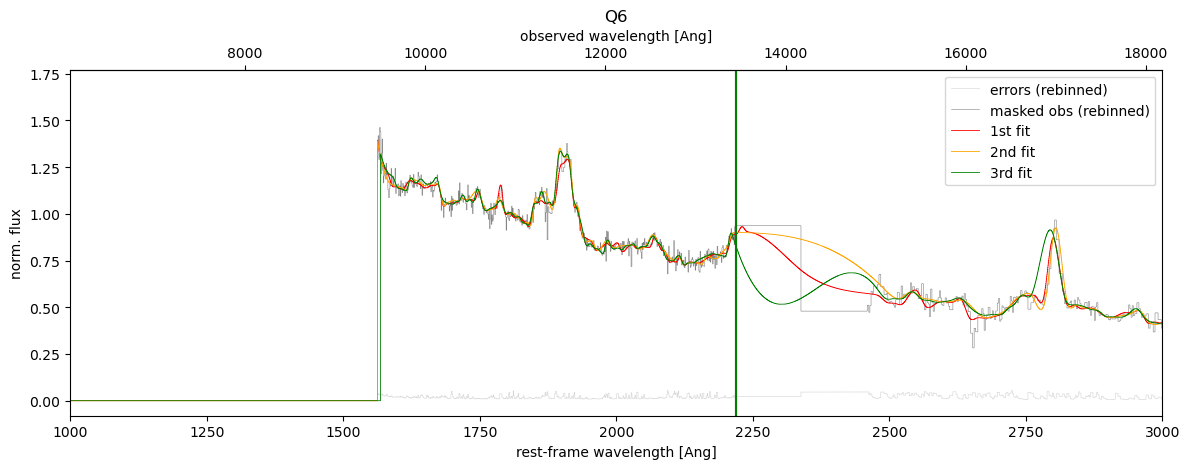

Q7


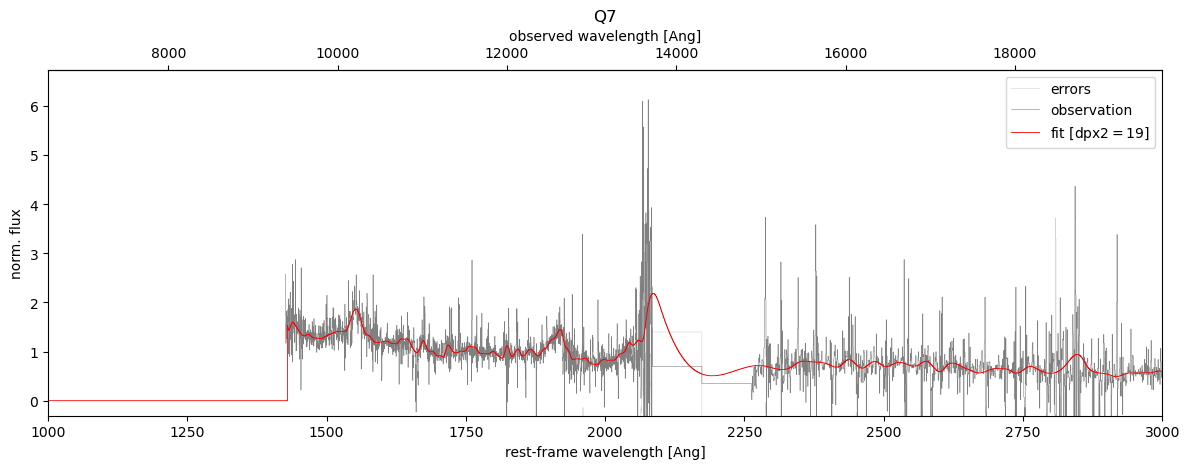

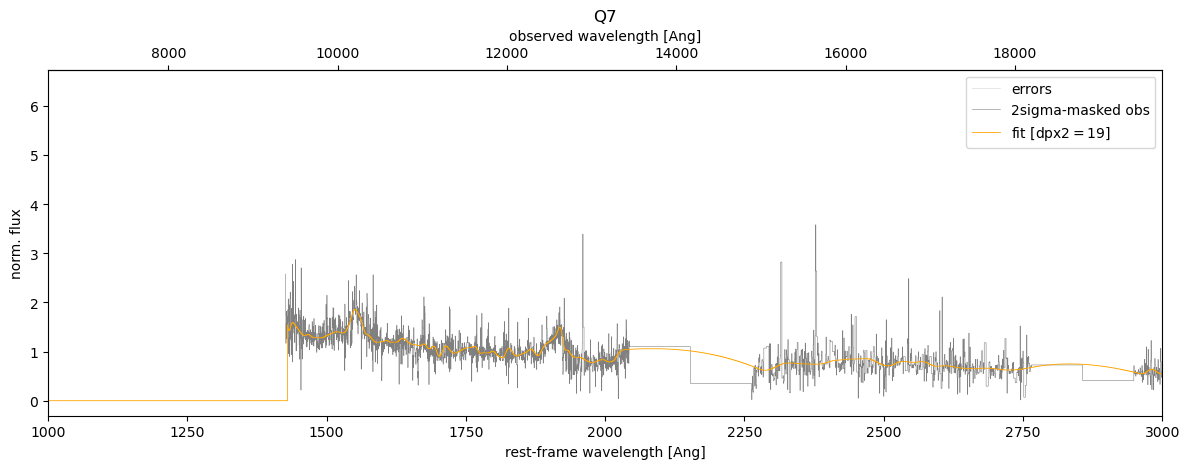

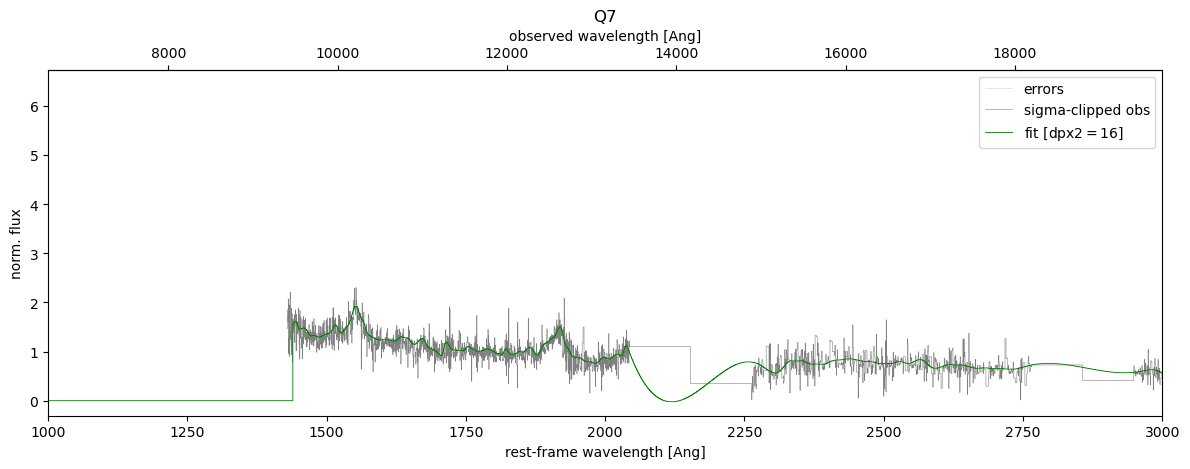

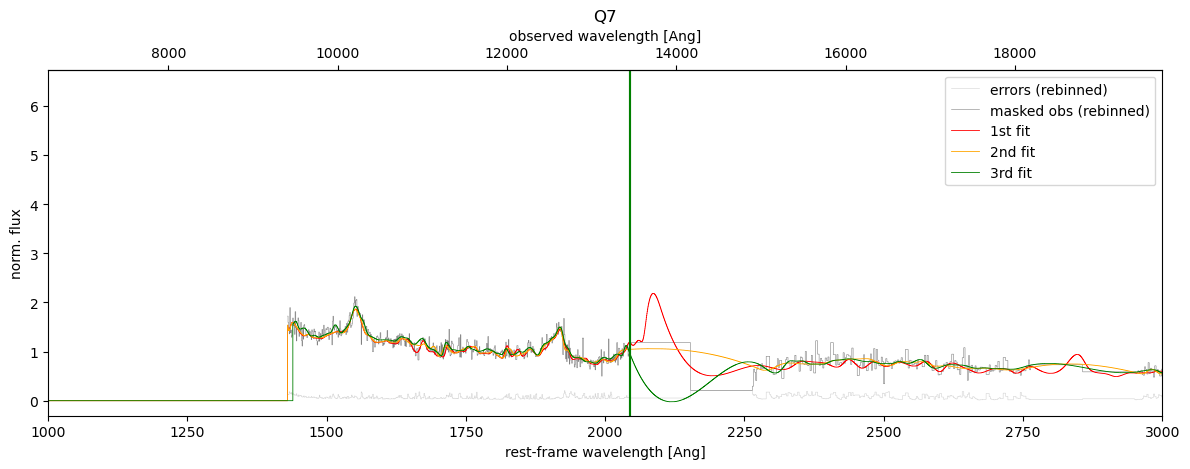

Q8


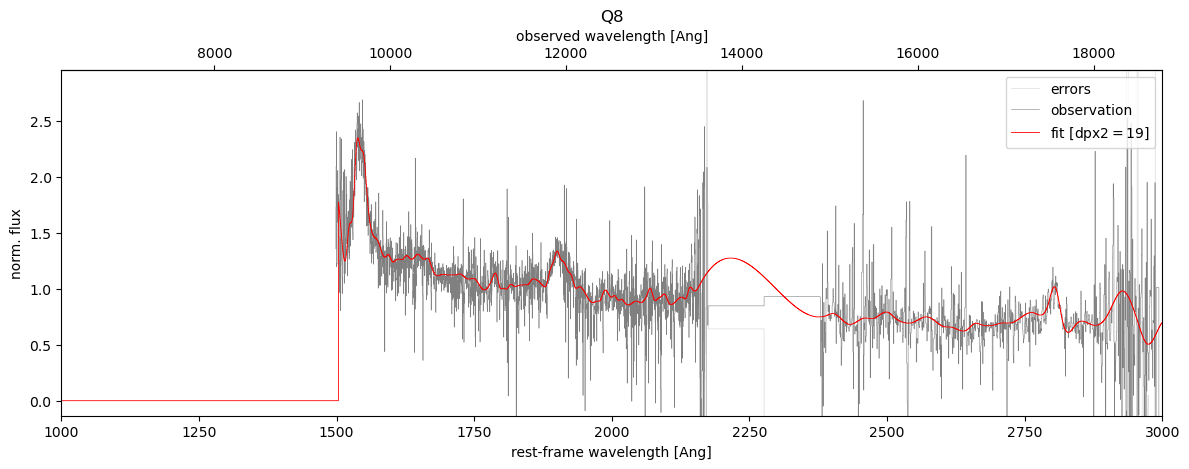

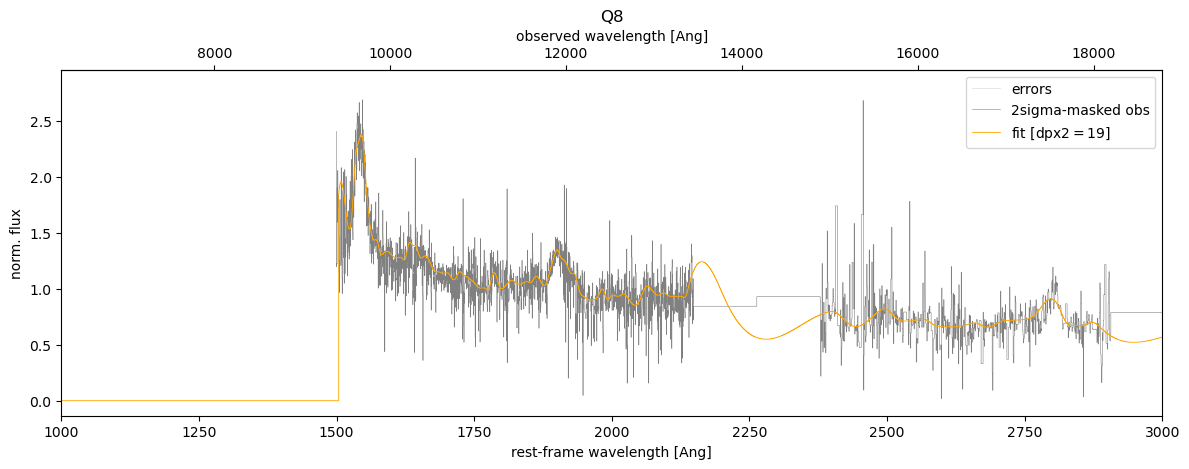

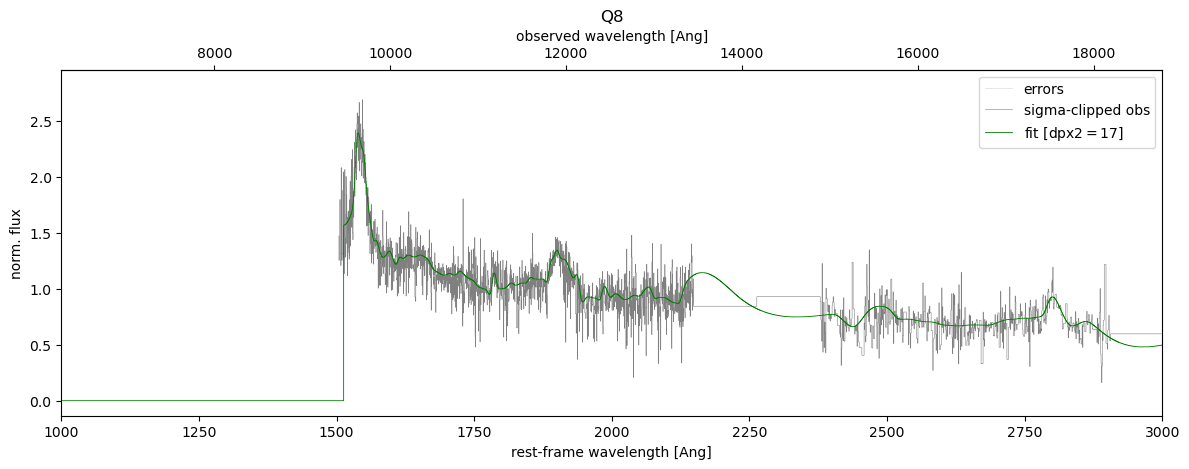

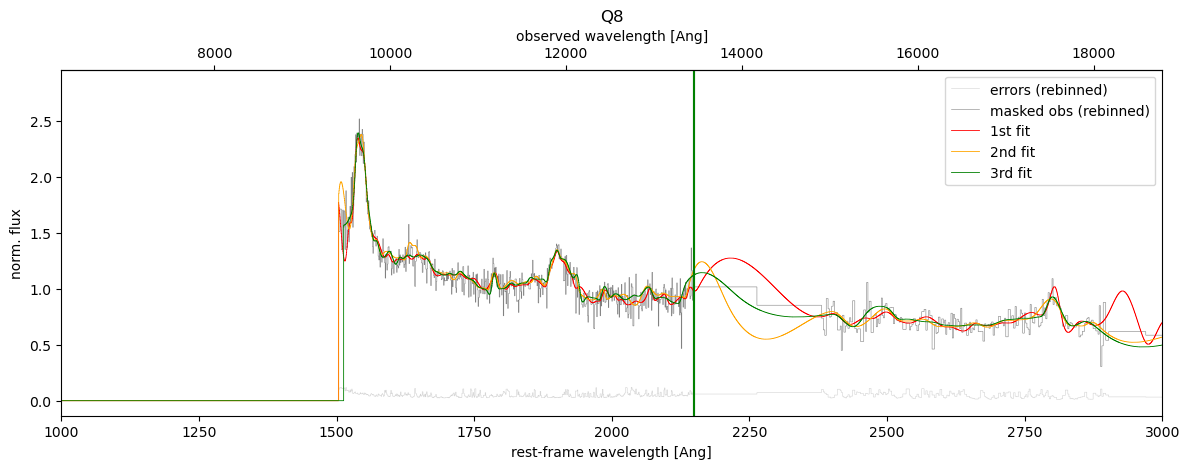

Q9


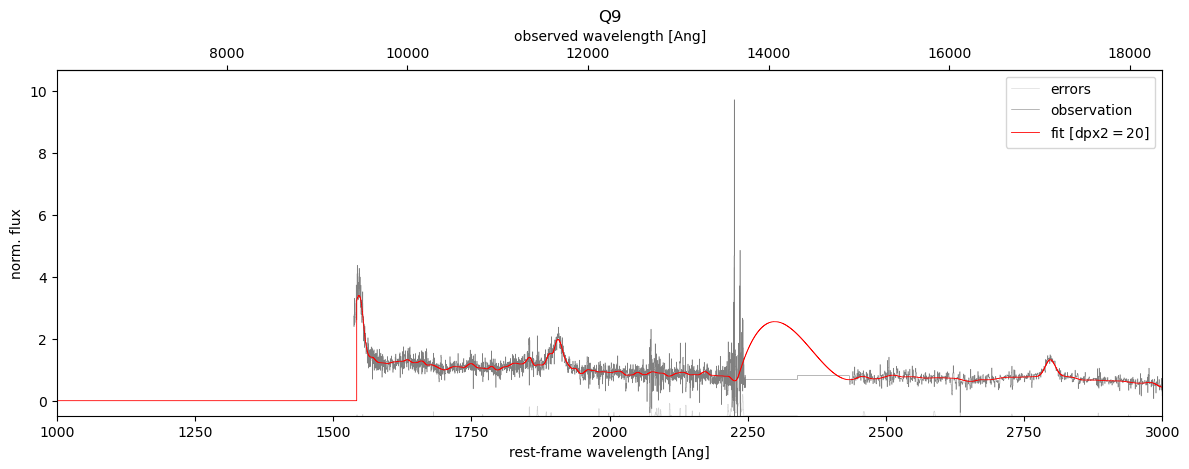

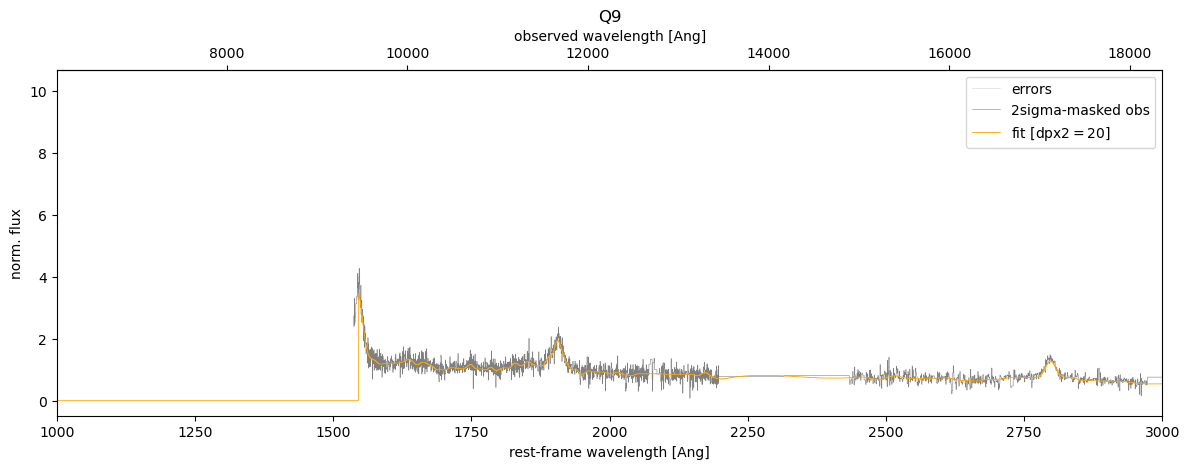

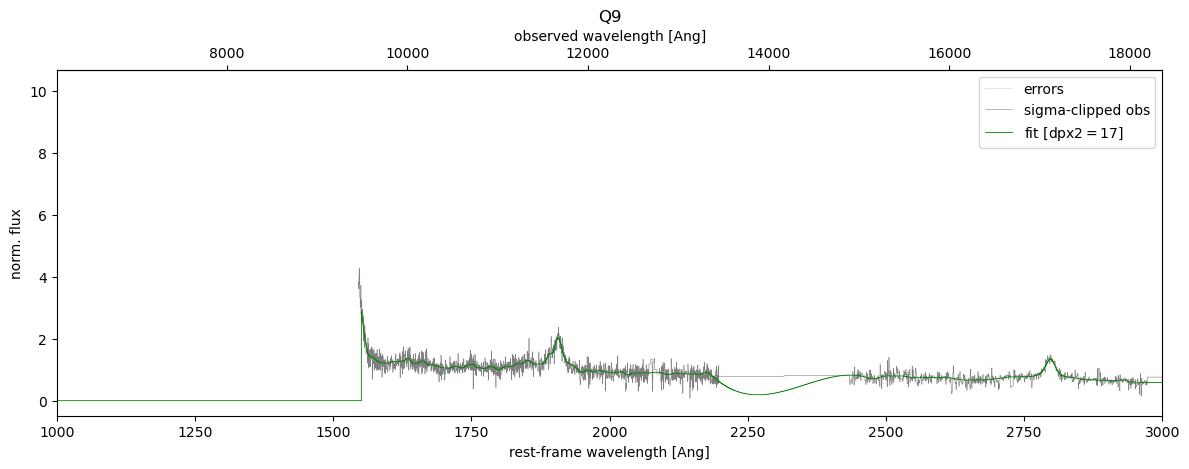

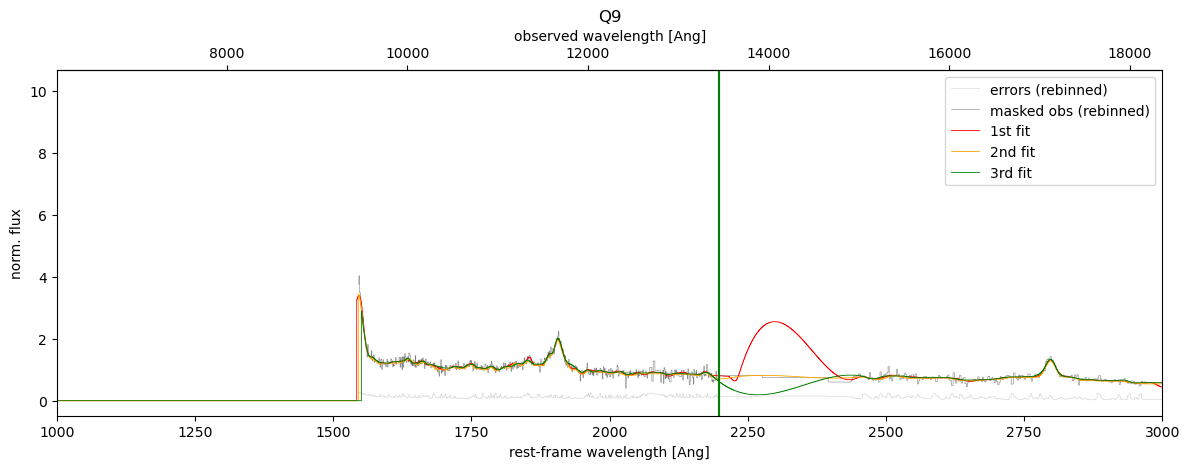

Q10


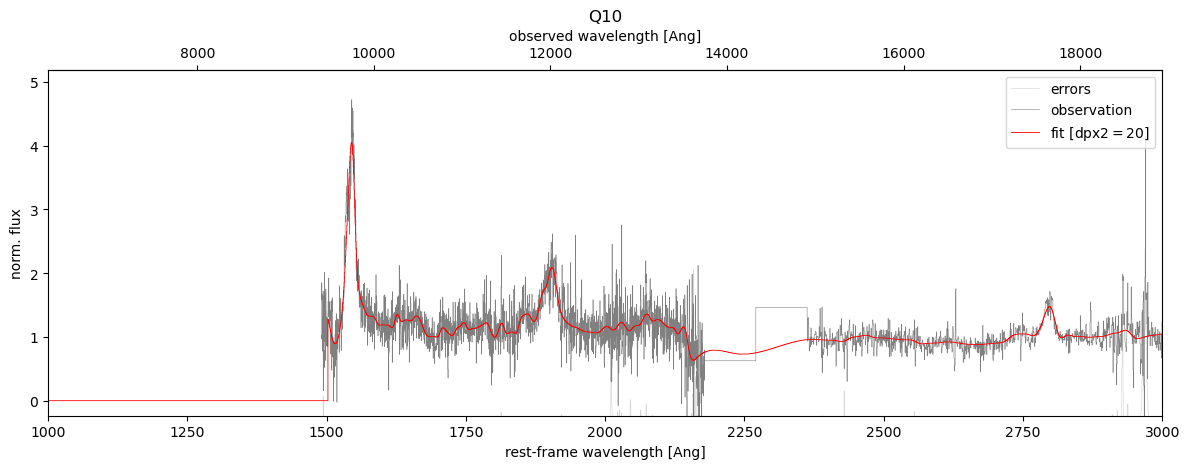

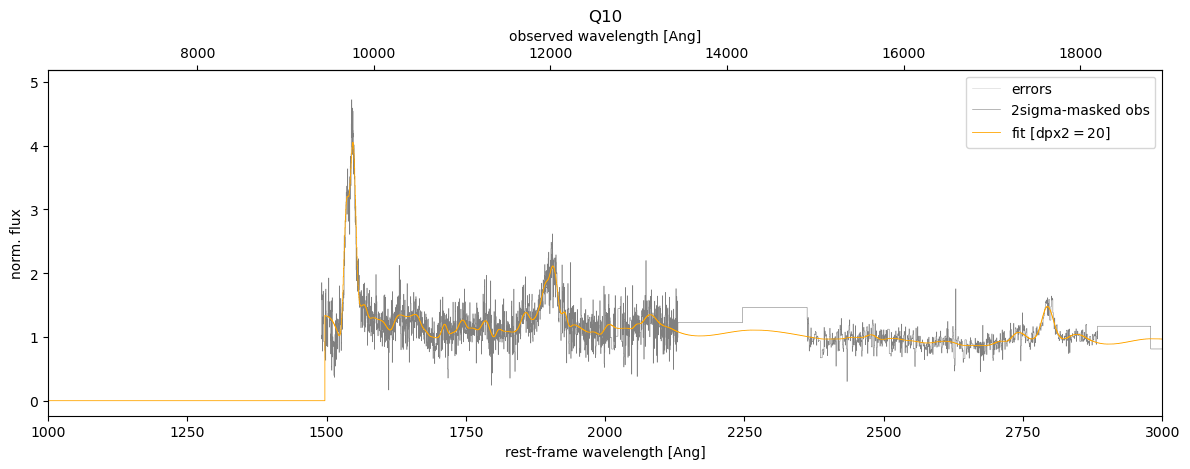

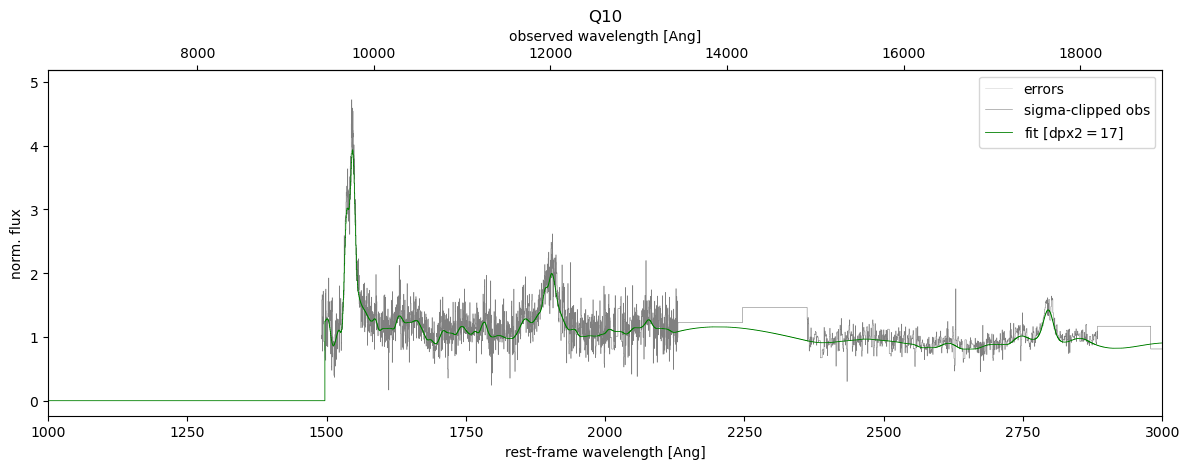

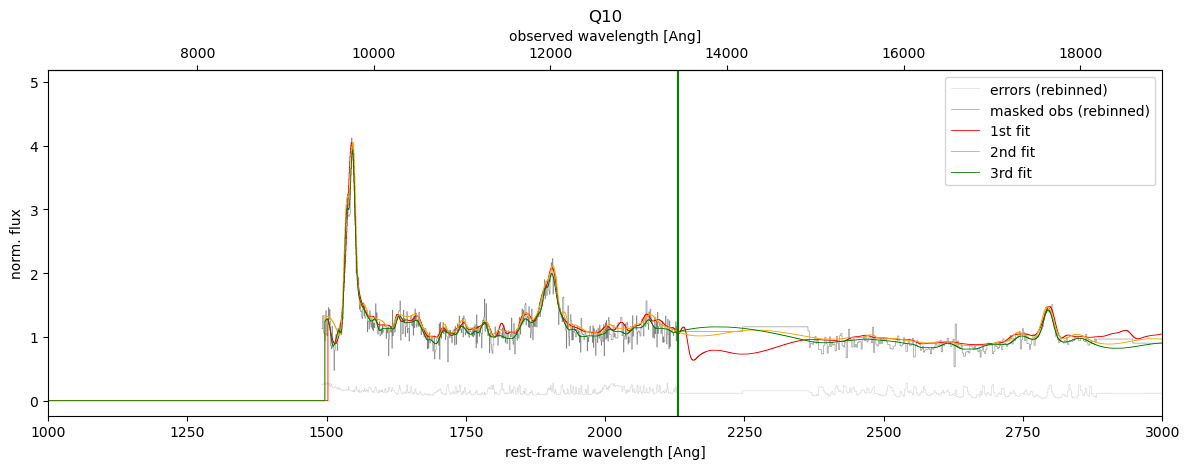

Q11


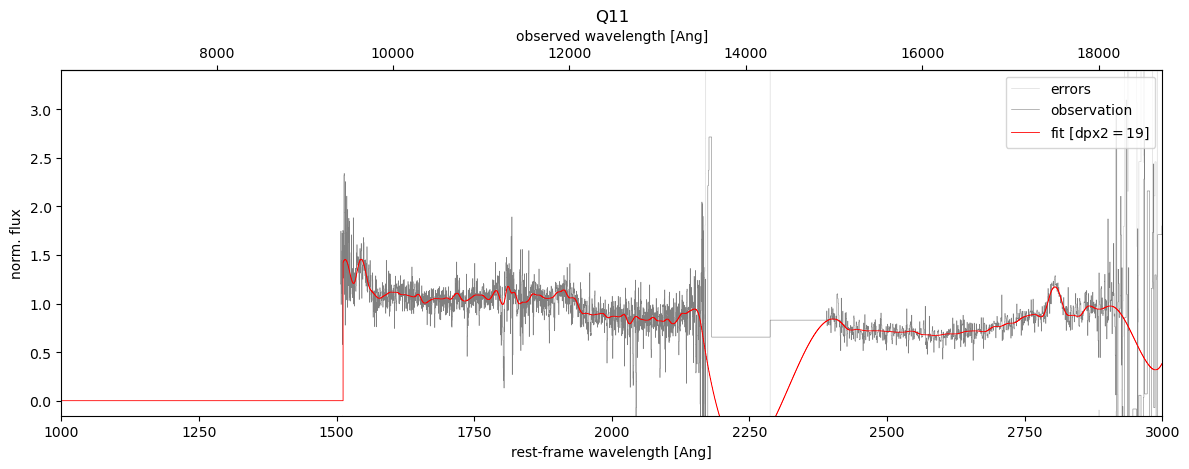

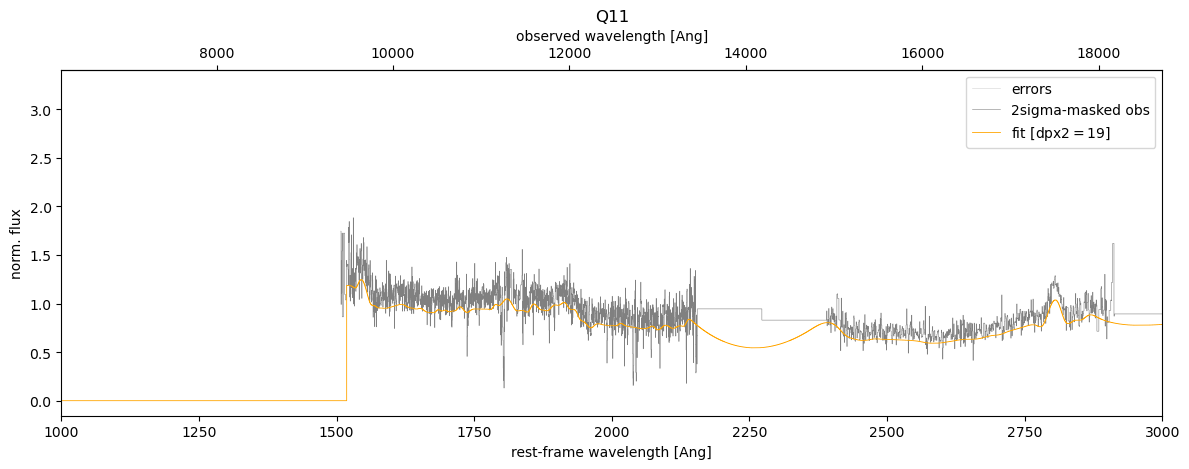

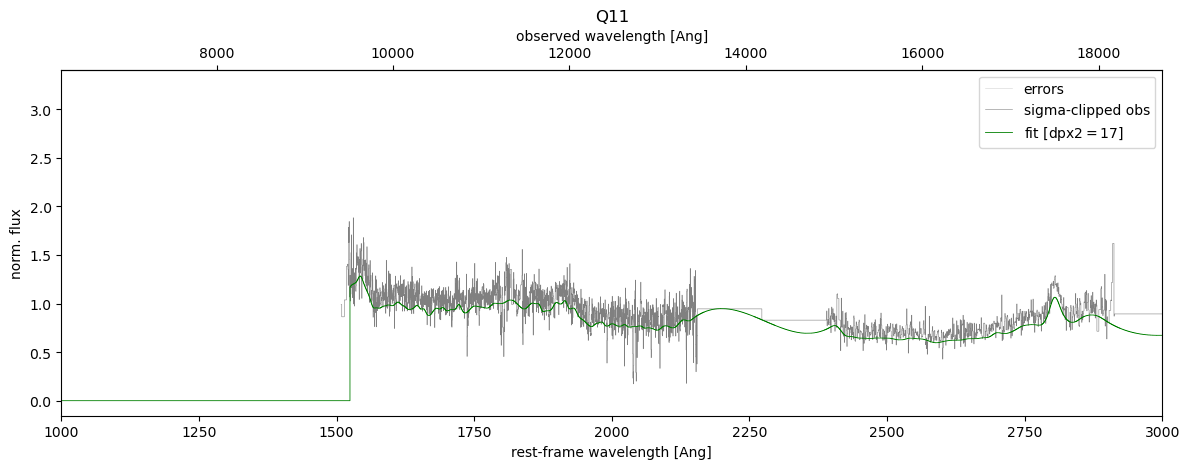

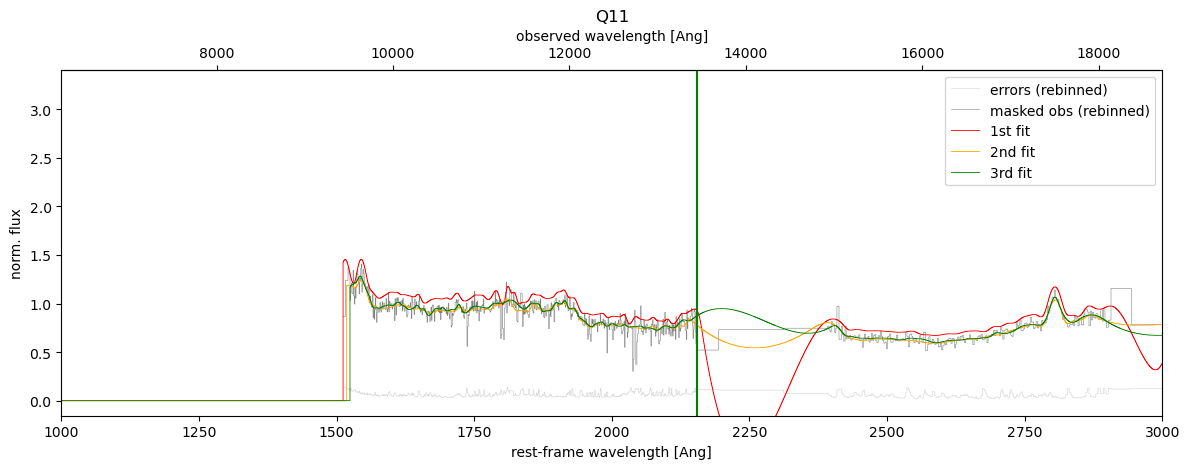

Q12


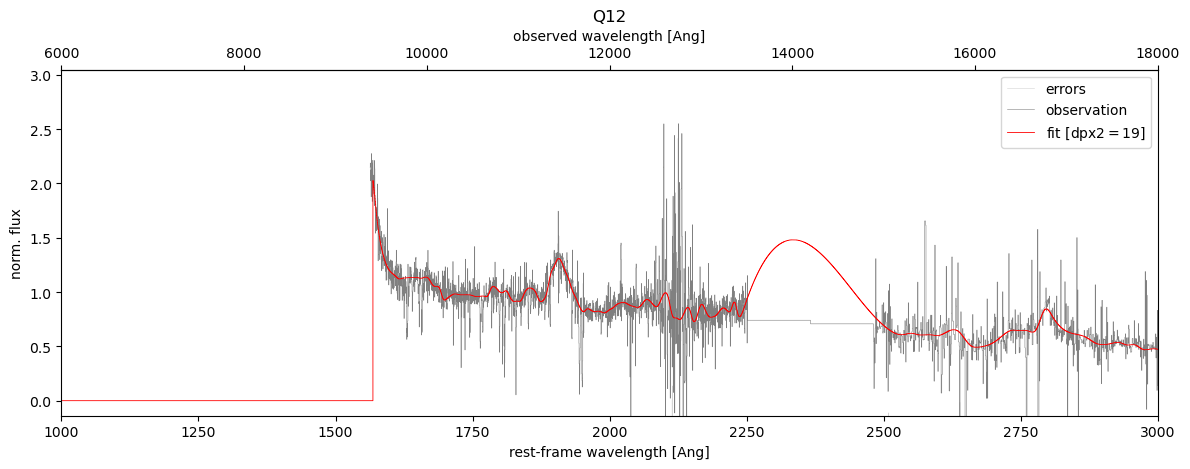

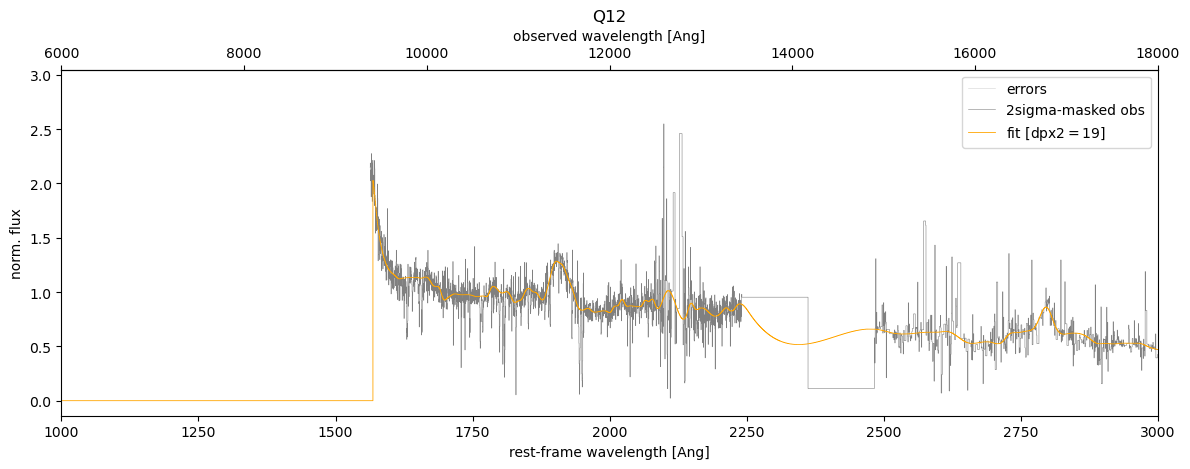

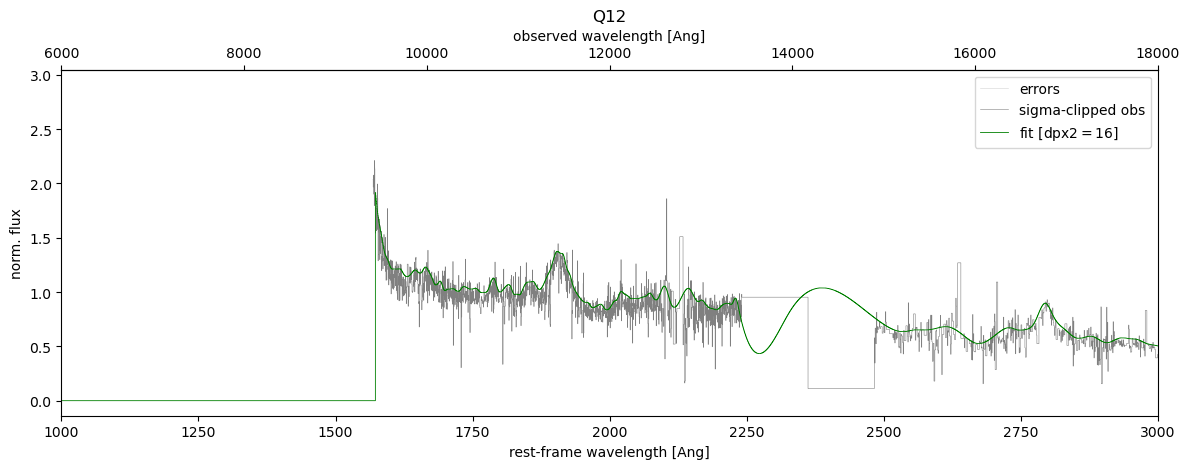

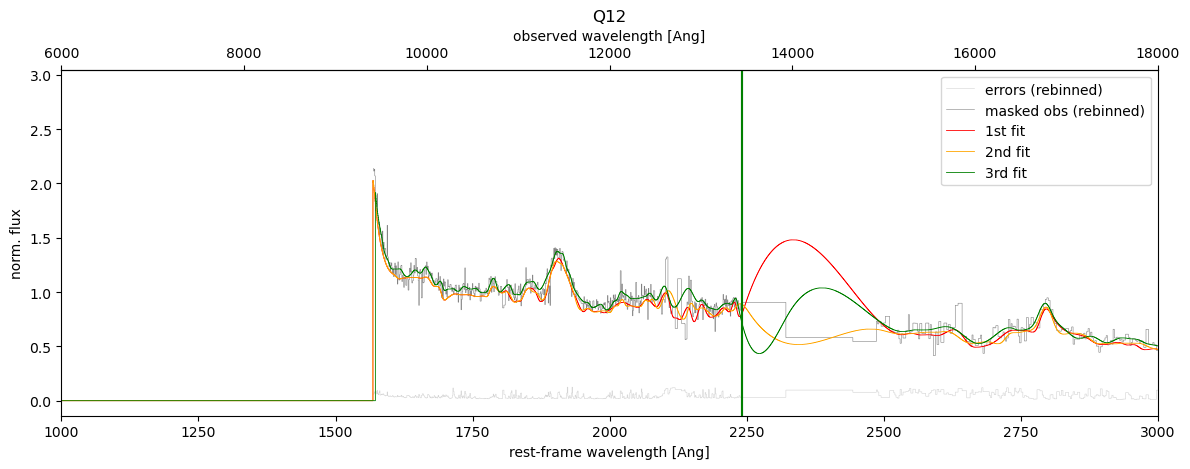

Q13


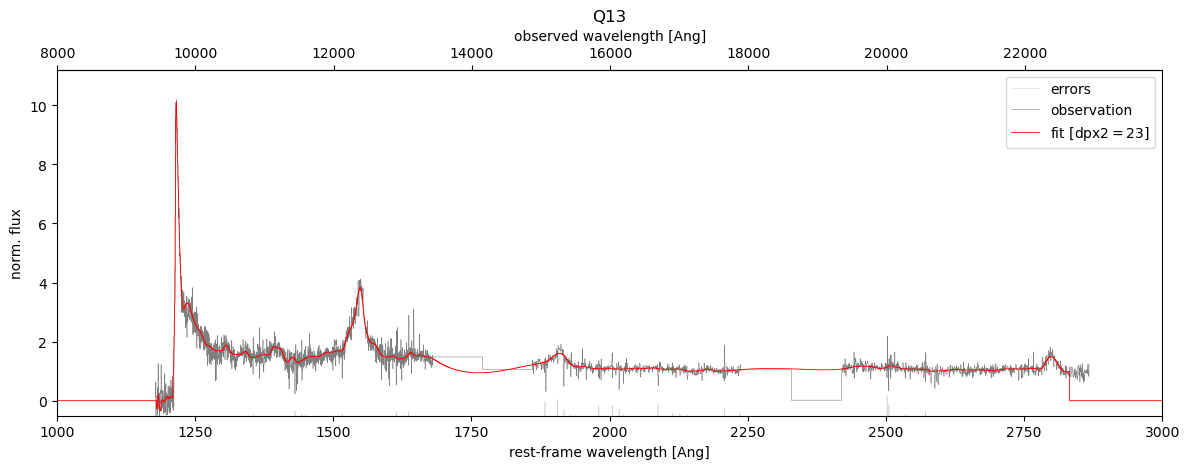

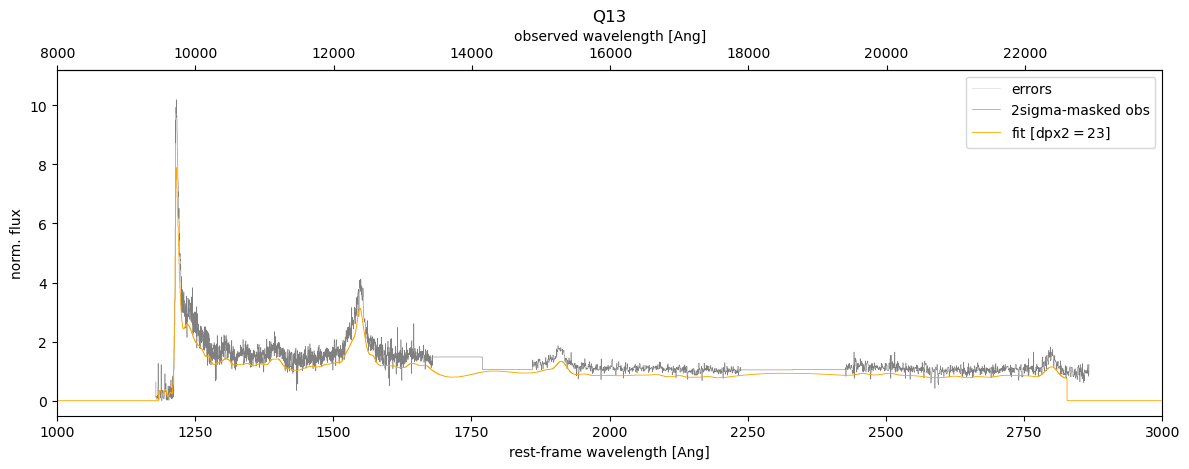

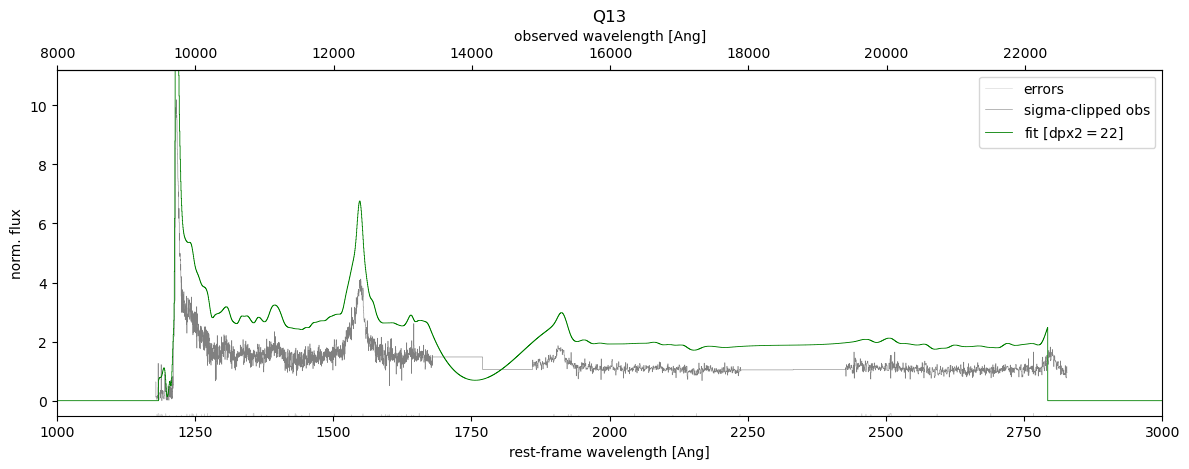

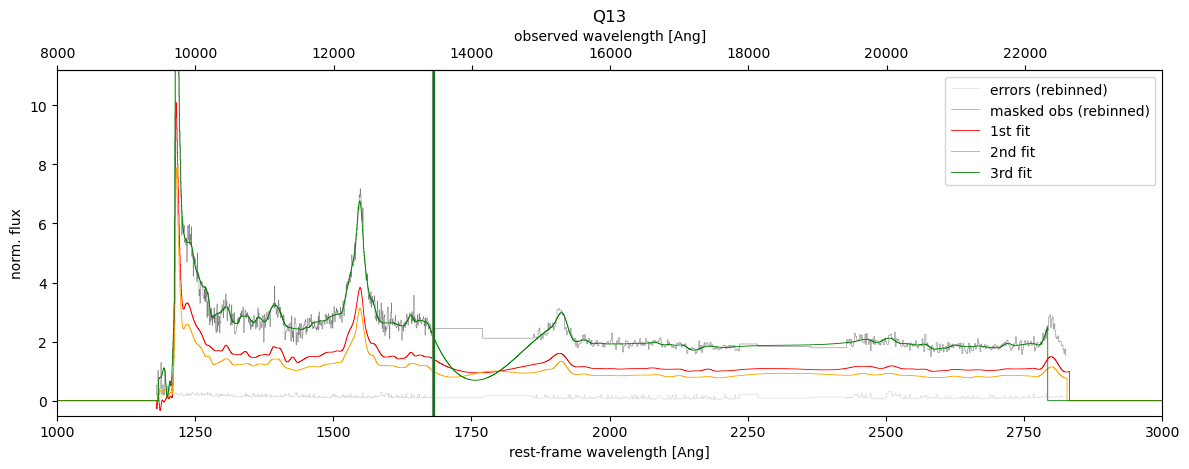

[1379.0, 1496.0, 1568.0, 1439.0, 1512.5, 1550.5, 1496.5, 1524.0, 1572.5, 2999.5]
[14885.019969102386, 14885.570505437146, 14884.977639106755, 14887.090558996453, 14887.879568414128, 14892.260472995786, 14905.148993983797, 14912.29986657092, 14894.839438404864, 14875.355378717572]


In [67]:
#pp = PdfPages('plots/data_cleaning_zoom.pdf')
minwl = [] #,w1r_new=[],[]
w1r_new=[14885.019969102386, 14885.570505437146, 14884.977639106755, 14887.090558996453, 14887.879568414128, 
         14892.260472995786, 14905.148993983797, 14912.29986657092, 14894.839438404864, 14250]
w1r_new=[]
for i,qname in enumerate(hnames):
    #w1r=w1r_new[i]
    print(qname)


    #pp = PdfPages('plots/{}_dc.pdf'.format(qname))
    fname = qname + '.csv'
    z_in = hz[i]
    w1l_r,w1r_r = w1l/(1+z_in),w1r/(1+z_in)

    # load spectrum
    spec = np.loadtxt(hspath + fname,delimiter=',',skiprows=1)
    wl, flux, sig = spec[:,0], spec[:,1], spec[:,2]
    mask_ini = np.logical_and(abs(flux) < 10, flux != 0)
    wl, flux, sig = wl[mask_ini], flux[mask_ini], sig[mask_ini]

    # count number of pixels in range 1250-2250 rest-frame
    npix_highz = len(wl[np.logical_and(wl>1250*(1+z_in),wl<2250*(1+z_in))]) 
    npix_eboss = 2553      # number of eboss spectrum pixels in range 1250 < wl < 2250
    dpx_eboss = 25         # deltapix2 used for eboss fits
    deltapix2 = round(dpx_eboss * npix_highz/npix_eboss)

    try:
        spec_fit, spec_norm, sigma_norm = spline_fit(wl,flux,sig,z_in,deltapix2)
        fval1 = mode(flux/spec_norm[1])[0]
        wl_normed,flux_normed = spec_norm[0],spec_norm[1]
        sig_normed = sigma_norm
        wl_fit,flux_fit = spec_fit[0],spec_fit[1]
        fit1 = spec_fit
        
    except Exception as error:               
        err = type(error).__name__
        print('1st fit was not possible:', err) 
        continue


    # define plot range
    #lya = 1215.67
    #lya_range = np.logical_and(spec_norm[0]>lya-30, spec_norm[0]<lya+30)
    #lya_max = max(spec_norm[1][lya_range])
    #ylimit = (-lya_max/4,lya_max*1.1)
    #xlimit = (min(wl_normed)-50,max(wl_normed)+50)
    #ylimit = (-lya_max*0.05,lya_max*0.7)
    ylimit = (-max(spec_norm[1])*0.05,max(spec_norm[1])*1.1)
    #ylimit = (-1.1,4)
    xlimit = (1000,3000)

    
    # plot spectrum and 1st fit
    fig1 = plt.figure(1)
    ax1 = fig1.subplots()
    fig1.set_figwidth(12)
    ax1.plot(wl_normed,sig_normed-1,linewidth=0.4, drawstyle='steps-mid', color='lightgrey',alpha=1,label='errors')
    ax1.plot(wl_normed,flux_normed,linewidth=0.4, drawstyle='steps-mid', color='grey',alpha=1,label='observation')
    ax1.plot(wl_fit,flux_fit,linewidth=0.6, drawstyle='steps-mid', color='red',alpha=1,label='fit [dpx2$={}$]'.format(deltapix2))
    #ax1.axvspan(2000,2200,color='white',zorder=3)
    ax1.set_xlim(xlimit)
    ax1.set_ylim(ylimit)
    ax1.set_xlabel('rest-frame wavelength [Ang]')
    ax1.set_ylabel('norm. flux')
    plt.legend(loc='upper right')
    plt.title(qname)

    sax1 = ax1.secondary_xaxis('top', functions=(func(z_in),inv(z_in)))
    sax1.set_xlabel('observed wavelength [Ang]')
    plt.tight_layout()

    #pp.savefig(fig1)
    plt.show()
    plt.close()
    

##### masking of entries with error > 2sig, and 2nd fit #####

    # mask both water absorption ranges
    mask1 = np.logical_or(wl<w1l,wl>w1r)
    mask2 = np.logical_or(wl<w2l,wl>w2r)
    mask3 = np.logical_and(mask1,mask2)
    #mask3 = mask1          # <------------------------------------------------------
    wl = wl[mask3]
    flux = flux[mask3]
    sig = sig[mask3]

    # stddev and mean of errors
    err_threshold = 2    #5*10**(-17)                   # add error threshold to mask values with very large systematic errors
    sig_std = np.std(sig[sig<err_threshold])
    sig_mean = np.mean(sig[sig<err_threshold])

    # # manual mask for Q4
    # lmask = wl<14000
    # rmask = wl>14000
    # sig_std1 = np.std(sig[wl<14000])
    # sig_mean1 = np.mean(sig[wl<14000])
    # sig_std2 = np.std(sig[wl>14000])
    # sig_mean2 = np.mean(sig[wl>14000])
    # llmask = np.logical_and(lmask,sig<=sig_mean1+1*sig_std1)
    # rrmask = np.logical_and(rmask,sig<=sig_mean2+2*sig_std2)
    # pmask = np.logical_or(llmask,rrmask)
    # mask = np.logical_and(pmask,flux>0)
    
    
    # mean of flux
    flux_median = np.median(flux[sig<err_threshold])
    
    # mask errors larger than 2 sigma and flux values close to zero
    mask = np.logical_and( sig <= sig_mean+2*sig_std, flux > 0.0*flux_median )
    
    
    # Apply mask to wavelength and flux arrays
    masked_wl = wl[mask]
    masked_flux = flux[mask]
    masked_sig = sig[mask]    
    
    # count number of pixels in range 1250-2250 rest-frame
    npix_highz = len(masked_wl[np.logical_and(masked_wl>1250*(1+z_in),masked_wl<2250*(1+z_in))])      # used to calculate the ratio 

    
    # apply 2nd fit to masked spectra
    npix_eboss = 2553      # number of eboss spectrum pixels in range 1250 < wl < 2250
    dpx_eboss = 25         # deltapix2 used for eboss fits
    #deltapix2 = round(dpx_eboss * npix_highz/npix_eboss) 

    try:
        spec_fit, spec_norm, sigma_norm = spline_fit(masked_wl,masked_flux,masked_sig,z_in,deltapix2)
        fit2 = spec_fit
        fval2 = mode(masked_flux/spec_norm[1])[0]
        
    except Exception as error:             # error most likely due to the signal magnitude being much larger than error threshold set before
        err = type(error).__name__
        print('1st fit was not possible:', err) 
        err_threshold = 5*10**(0)         # decrease error threshold and re-do masking
        sig_std = np.std(sig[sig<err_threshold])
        sig_mean = np.mean(sig[sig<err_threshold])
        mask = sig <= sig_mean+2*sig_std
        masked_wl = wl[mask]
        masked_flux = flux[mask]
        masked_sig = sig[mask]
        npix_highz = len(masked_wl[np.logical_and(masked_wl>1250*(1+z_in),masked_wl<2250*(1+z_in))]) 
        #deltapix2 = round(dpx_eboss * npix_highz/npix_eboss) 

        try:
            spec_fit, spec_norm, sigma_norm = spline_fit(masked_wl,masked_flux,masked_sig,z_in,deltapix2)
            fit2 = spec_fit
            fval2 = mode(masked_flux/spec_norm[1])[0]
            
        except Exception as error:
            err = type(error).__name__
            print('2nd fit was not possible:', err) 
            print(masked_wl)
            continue
    
    spec_norm2 = spec_norm
    sigma_norm2 = sigma_norm
    
    # plot masked spectrum and fit
    fig2 = plt.figure(2)
    ax2 = fig2.subplots()
    fig2.set_figwidth(12)
    ax2.plot(spec_norm[0],sigma_norm-1,linewidth=0.4, drawstyle='steps-mid', color='lightgrey',alpha=1,label='errors')
    ax2.plot(spec_norm[0],spec_norm[1]*fval2/fval1,linewidth=0.4, drawstyle='steps-mid', color='grey',alpha=1,label='2sigma-masked obs')   #normalization by fval1 necessary in case of 1st fit!
    ax2.plot(spec_fit[0],spec_fit[1],linewidth=0.6,drawstyle='steps-mid',color='orange',alpha=1,label='fit [dpx2$={}$]'.format(deltapix2))
    ax2.set_xlim(xlimit)
    ax2.set_ylim(ylimit)
    ax2.set_xlabel('rest-frame wavelength [Ang]')
    ax2.set_ylabel('norm. flux')
    plt.legend(loc='upper right')
    plt.title(qname)

    sax2 = ax2.secondary_xaxis('top', functions=(func(z_in),inv(z_in)))
    sax2.set_xlabel('observed wavelength [Ang]')
    plt.tight_layout()

    #pp.savefig(fig2)
    plt.show()
    plt.close()
    

##### sigma clipping ####

    #fit_interp = np.array([np.interp(k,spec_fit[0],spec_fit[1]) for k in spec_norm2[0]])
    diff = [abs(np.interp(spec_norm[0][k],spec_fit[0],spec_fit[1])-spec_norm[1][k]) for k in range(len(spec_norm[0]))]
    mask41 = [diff[k]<4*sigma_norm[k] for k in range(len(spec_norm[0]))]
    #wl_zero = min(spec_fit[0][np.logical_and(spec_fit[1]==0,spec_fit[0]>1250)])
    #print(wl_zero)
    #mask42 = spec_norm[0] > wl_zero
    mask4 = mask41   #np.logical_or(mask41,mask42)
    masked2_wl = masked_wl[mask4]
    masked2_flux = masked_flux[mask4]
    masked2_sig = masked_sig[mask4]
    

    # update deltapix after masking
    npix_highz = len(masked2_wl[np.logical_and(masked2_wl>1250*(1+z_in),masked2_wl<2250*(1+z_in))])     
    deltapix2 = round(dpx_eboss * npix_highz/npix_eboss)       
    #deltapix2 = 19
    try:
        spec_fit, spec_norm, sigma_norm = spline_fit(masked2_wl,masked2_flux,masked2_sig,z_in,deltapix2)
        fit3 = spec_fit
        fval3 = mode(masked2_flux/spec_norm[1])[0]

        #pseudo_fit, _ , _ = spline_fit(spec_norm2[0]*(1+z_in),pseudo_flux,sigma_norm2,z_in,deltapix2)
    except Exception as error:
        err = type(error).__name__
        print('sigma clipping not possible:', err) 
        continue
    
    
    # # save fit + normalised spectrum
    # norm_save='{}_norm'.format(qname)
    # with open(hnpath + norm_save + '.txt','w') as nsave:
    #     for x in itertools.zip_longest(*spec_norm,sigma_norm):
    #         nsave.write('{} \t {} \t {}\n'.format(*x))
    # nsave.close()


    # fit_save='{}_dpx{}'.format(qname,deltapix2)
    # with open(hfpath + fit_save + '.txt','w') as fsave:
    #     for x in itertools.zip_longest(*spec_fit):
    #         fsave.write('{} \t {}\n'.format(*x))
    # fsave.close()
    
    minwl.append(max(spec_fit[0][spec_fit[1]==0]))
    

    # find wavelength range with unavailable spectrum
    # Initialize variables to store indices of maximum difference
    max_diff_indices = None
    max_diff = -float('inf')  # Initialize with negative infinity
    
    # Iterate over the array to find the maximum difference
    for i in range(len(masked2_wl) - 1):
        if masked2_wl[i]>16000:
            continue
        diff = abs(masked2_wl[i+1] - masked2_wl[i])
        if diff > max_diff:
            max_diff = diff
            max_diff_indices = (i, i+1)
    max_diff_min, max_diff_max = masked2_wl[max_diff_indices[0]],masked2_wl[max_diff_indices[1]]
    w1r_new.append(max_diff_max)
    
    
    # plot masked spectrum and fit
    fig3 = plt.figure(3)
    ax3 = fig3.subplots()
    fig3.set_figwidth(12)
    ax3.plot(spec_norm[0],sigma_norm-1,linewidth=0.4, drawstyle='steps-mid', color='lightgrey',alpha=1,label='errors')
    ax3.plot(spec_norm[0],spec_norm[1]*fval3/fval1,linewidth=0.4, drawstyle='steps-mid', color='grey',alpha=1,label='sigma-clipped obs')
    ax3.plot(spec_fit[0],spec_fit[1],linewidth=0.6,drawstyle='steps-mid',color='green',alpha=1,label='fit [dpx2$={}$]'.format(deltapix2))
    #ax3.axvspan(1970,2210,color='white',zorder=3)
    #ax3.axvline(1970)
    ax3.set_xlim(xlimit)
    ax3.set_ylim(ylimit)
    ax3.set_xlabel('rest-frame wavelength [Ang]')
    ax3.set_ylabel('norm. flux')
    plt.legend(loc='upper right')
    plt.title(qname)

    sax3 = ax3.secondary_xaxis('top', functions=(func(z_in),inv(z_in)))
    sax3.set_xlabel('observed wavelength [Ang]')
    plt.tight_layout()

    #pp.savefig(fig3)
    plt.show()
    plt.close()


###### rebinning of spectra #####

    # rebin spectrum
    bin_size = 3
    wl_rebin,flux_rebin,sig_rebin=[],[],[]
    j = 0
    while j <= len(spec_norm[0])-bin_size:
        wl_rebin.append(np.mean(spec_norm[0][j:j+bin_size]))
        flux_rebin.append(np.mean(spec_norm[1][j:j+bin_size]))
        sig_rebin.append(np.sqrt(np.sum([k**2 for k in sigma_norm[j:j+bin_size]]))/3)
        j+=bin_size

    # plot rebinned spectrum and all previous fit
    fig4 = plt.figure(4)
    ax4 = fig4.subplots()
    fig4.set_figwidth(12)
    ax4.plot(wl_rebin,sig_rebin,linewidth=0.4, drawstyle='steps-mid', color='lightgrey',alpha=1,label='errors (rebinned)')
    ax4.plot(wl_rebin,flux_rebin,linewidth=0.4, drawstyle='steps-mid', color='grey',alpha=1,label='masked obs (rebinned)')
    ax4.plot(*fit1,linewidth=0.6,drawstyle='steps-mid',color='red',alpha=1,label='1st fit')
    ax4.plot(*fit2,linewidth=0.6,drawstyle='steps-mid',color='orange',alpha=1,label='2nd fit')
    ax4.plot(*fit3,linewidth=0.6,drawstyle='steps-mid',color='green',alpha=1,label='3rd fit')
    #ax4.axvspan(max_diff_min/(1+z_in),max_diff_max/(1+z_in),color='grey',alpha=0.3)
    #ax4.axvspan(w1l/(1+z_in),w1r/(1+z_in),color='green',alpha=0.3)
    ax4.axvline(max_diff_min/(1+z_in),color='grey')
    ax4.axvline(w1l/(1+z_in),color='green')
    ax4.set_xlim(xlimit)
    ax4.set_ylim(ylimit)
    ax4.set_xlabel('rest-frame wavelength [Ang]')
    ax4.set_ylabel('norm. flux')
    plt.legend(loc='upper right')
    plt.title(qname)

    sax4 = ax4.secondary_xaxis('top', functions=(func(z_in),inv(z_in)))
    sax4.set_xlabel('observed wavelength [Ang]')
    plt.tight_layout()

    #pp.savefig(fig4)
    plt.show()
    plt.close()
    
#pp.close()
print(minwl)
print(w1r_new)

In [4]:
hdpath = hpath
hfpath = hdpath + 'fits/'#sigma_clipped/'
hnpath = hdpath + 'normed/'#sigma_clipped/'

def plot_xdata(idx,fig,ax,c,lw,bs):
    filename = glob.glob(hnpath + '{}_norm.txt'.format(idx))[0]
    normed = np.loadtxt(filename)

    norm_wl = normed[:,0]
    norm_flux = normed[:,1]
    norm_sig = normed[:,2]

    if bs == 1:
        #ax.plot(norm_wl,norm_sig,linewidth=lw*0.8,drawstyle='steps-mid',color=c,alpha=0.5,label='errors')
        ax.plot(norm_wl,norm_flux,linewidth=lw, drawstyle='steps-mid', color=c,alpha=0.5,label='normed observation')

    else:
        bin_size = bs
        wl_rebin,flux_rebin,sig_rebin=[],[],[]
        j = 0
        while j <= len(norm_wl)-bin_size:
            wl_rebin.append(np.mean(norm_wl[j:j+bin_size]))
            flux_rebin.append(np.mean(norm_flux[j:j+bin_size]))
            sig_rebin.append(np.sqrt(np.sum([k**2 for k in norm_sig[j:j+bin_size]]))/3)
            j+=bin_size

        ax.plot(wl_rebin,flux_rebin,linewidth=lw, drawstyle='steps-mid', color=c,alpha=0.5,label='normed observation')       
    return

def plot_xfit(idx,z,fig,ax,c,lw,wl_l,wl_r):

    filename = glob.glob(hfpath + '{}_*.txt'.format(idx))[0]
    fit = np.loadtxt(filename)

    fit_wl = fit[:,0]
    fit_flux = fit[:,1]

    # hide fit in excluded regions
    wmask1 = np.logical_or(fit_wl<w1l/(1+z),fit_wl>w1r/(1+z))
    wmask2 = np.logical_or(fit_wl<w2l/(1+z),fit_wl>w2r/(1+z))
    wmask = np.logical_and(wmask1,wmask2)
    
    mask1 = fit_wl > 1250
    mask2 = fit_wl < 2250
    mask = np.logical_and(mask1,mask2)

    #ax.plot(fit_wl[wmask],fit_flux[wmask],linewidth=lw, drawstyle='steps-mid', color=c,label='spline fit', zorder=1)
    ax.plot(fit_wl,fit_flux,linewidth=lw, drawstyle='steps-mid', color=c,label='spline fit', zorder=1)
    #ax.fill_between(fit_wl[~wmask], 2*max(fit_flux),-max(fit_flux),color='white',zorder=2)
    ax.axvspan(wl_l,wl_r/(1+z),facecolor='white',zorder=2)
    ax.axvspan(w2l/(1+z),w2r/(1+z),facecolor='white',zorder=2)
    #ax.axvspan(min(min(norm_wl),min(fit_wl)),1250,alpha=0.2,facecolor='grey')
    #ax.axvspan(2250,max(max(norm_wl),max(fit_wl)),alpha=0.2,facecolor='grey')
    #ax.set_xlim(left=min(min(norm_wl),min(fit_wl)),right=max(max(norm_wl),max(fit_wl)))
    return max(fit_flux[mask])


lfpath = '/media/bartosz/USB STICK/BOSS_DR14/fits/'
lnpath = '/media/bartosz/USB STICK/BOSS_DR14/normed/'

def plot_fit(idx,fig,ax,c,lw):

    filename = glob.glob(lfpath + '{}_*_0_dpx25.txt'.format(idx))[0]
    fit = np.loadtxt(filename)

    fit_wl = fit[:,0]
    fit_flux = fit[:,1]
    fit_flux = fit_flux/fit_flux[1600]   #normalization at 1800 Ang

    mask1 = fit_wl > 1250
    mask2 = fit_wl < 2250
    mask = np.logical_and(mask1,mask2)

    ax.plot(fit_wl,fit_flux,linewidth=lw, drawstyle='steps-mid', color=c, alpha=0.6,label='idx {}'.format(idx))
    return max(fit_flux[mask])


def plot_norm(idx,fig,ax,c,lw):
    filename = glob.glob(lnpath + '{}_*_norm.txt'.format(idx))[0]
    norm = np.loadtxt(filename)

    filename = glob.glob(lfpath + '{}_*_0_dpx25.txt'.format(idx))[0]   #normalization at 1800 Ang
    fit = np.loadtxt(filename)   #normalization at 1800 Ang

    fit_flux = fit[:,1]   #normalization at 1800 Ang
    
    norm_wl = norm[:,0]
    norm_flux = norm[:,1]
    norm_flux = norm[:,1]/fit_flux[1600]   #normalization at 1800 Ang

    ax.plot(norm_wl,norm_flux,linewidth=lw, drawstyle='steps-mid', color=c, alpha=0.6) #, label='norm. data')
    return

    
def func(z):
    def func2(x):
        return x*(1+z)
    return func2

def inv(z):
    def inv2(x):
        return x/(1+z)
    return inv2

In [11]:
custom_lines = [Line2D([0], [0], color='r', lw=1),
                Line2D([0], [0], color='b', lw=1),
                Patch(facecolor='grey', alpha=0.4)]

hmeta = np.loadtxt(hdpath + 'notes',dtype='str')
qlist = hmeta[:,0]
hZ = hmeta[:,1]

NN = np.loadtxt(hdpath + 'rl_NN_full_sc_v2.txt', dtype='str')
qlist_NN = NN[:,0]
IDX_NN = NN[:,1:6]
D_NN = NN[:,51:56] #[:,6:11]

w1l_new=[1970,2125,2200,2025,2125,2150,2131.5,2150,2225]
w1r_new=[14885.019969102386, 14885.570505437146, 14884.977639106755, 14887.090558996453, 14887.879568414128, 
         14892.260472995786, 14905.148993983797, 14912.29986657092, 14894.839438404864, 14875.355378717572]
starts = [1379.0, 1496.0, 1568.0, 1439.0, 1512.5, 1550.5, 1496.5, 1524.0, 1572.5, 1250]

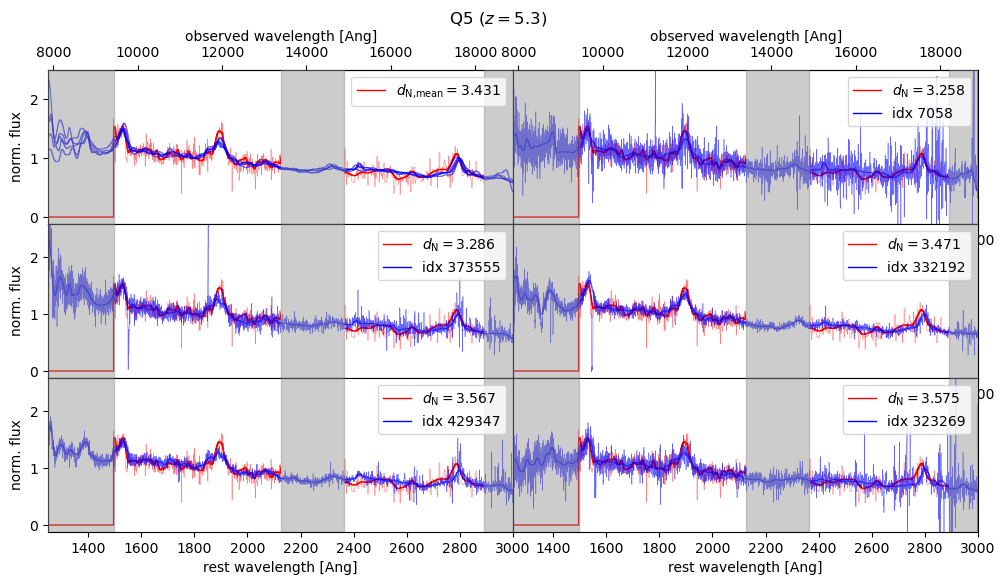

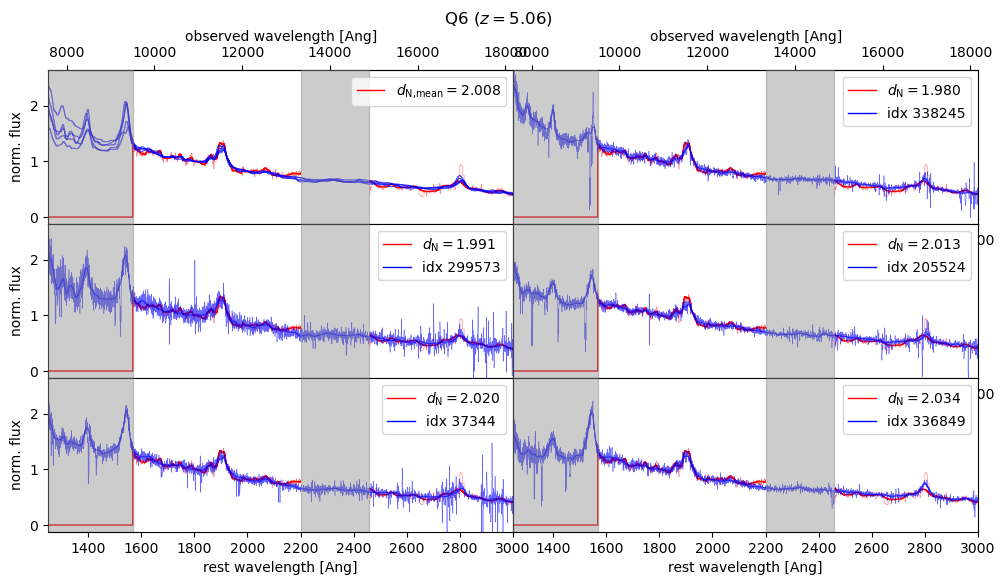

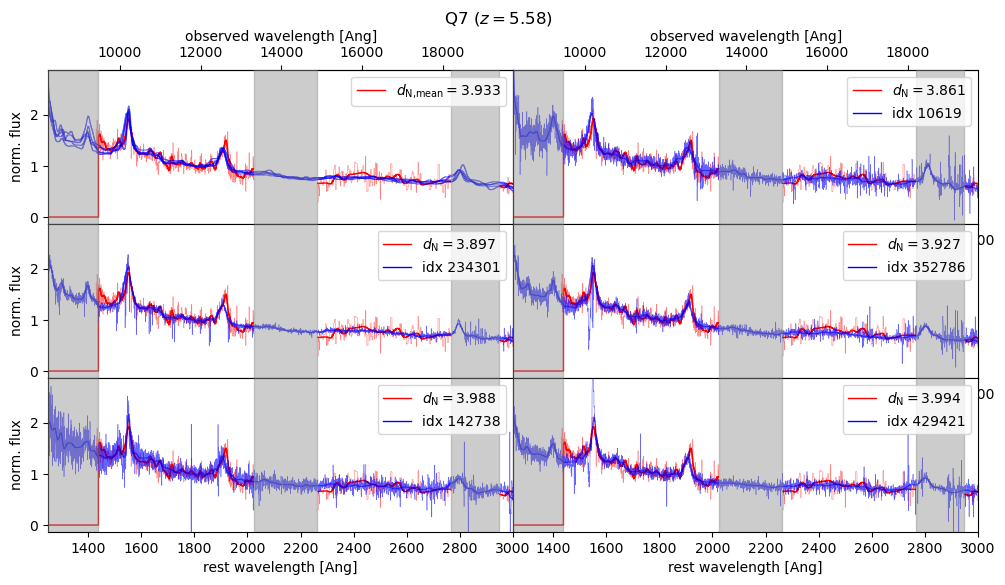

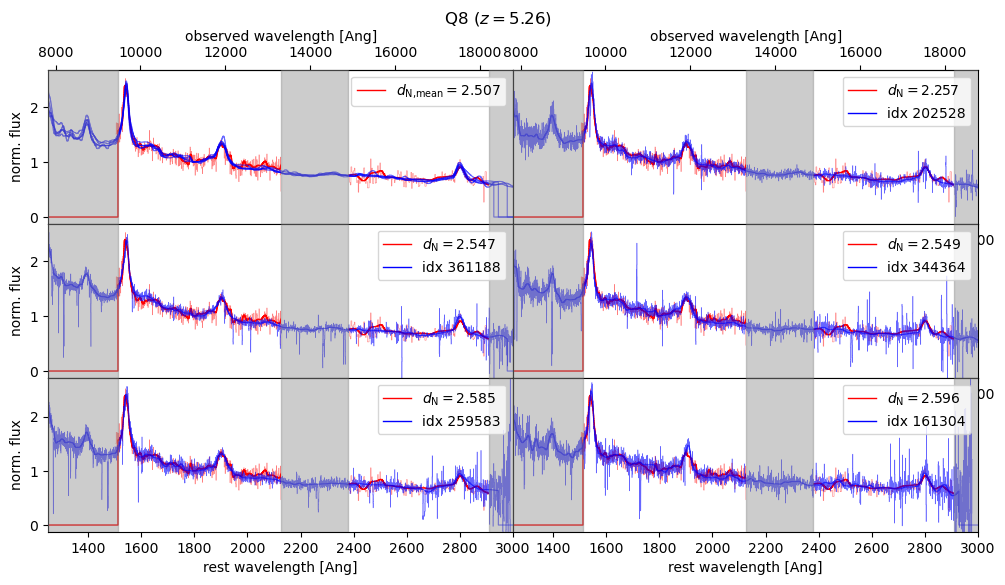

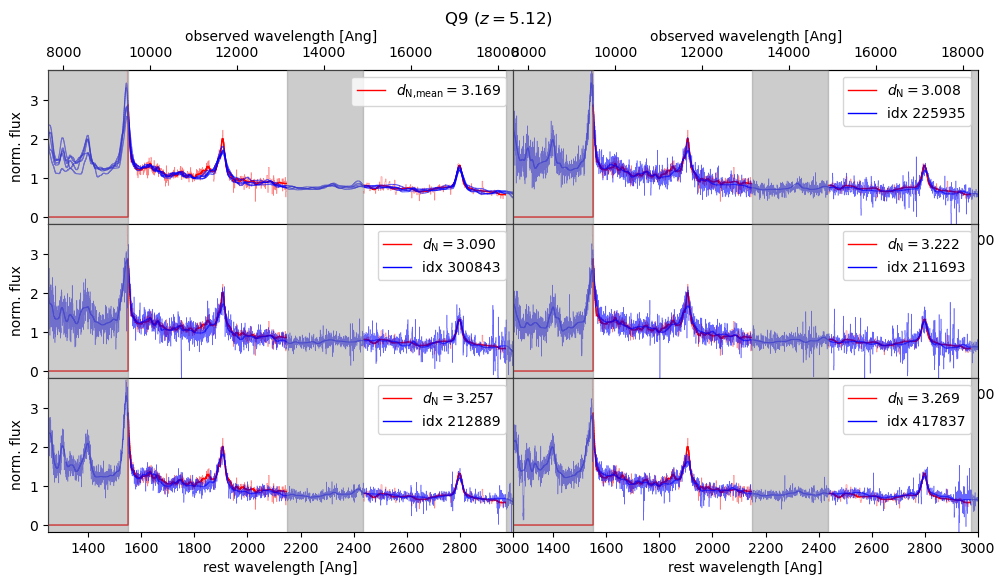

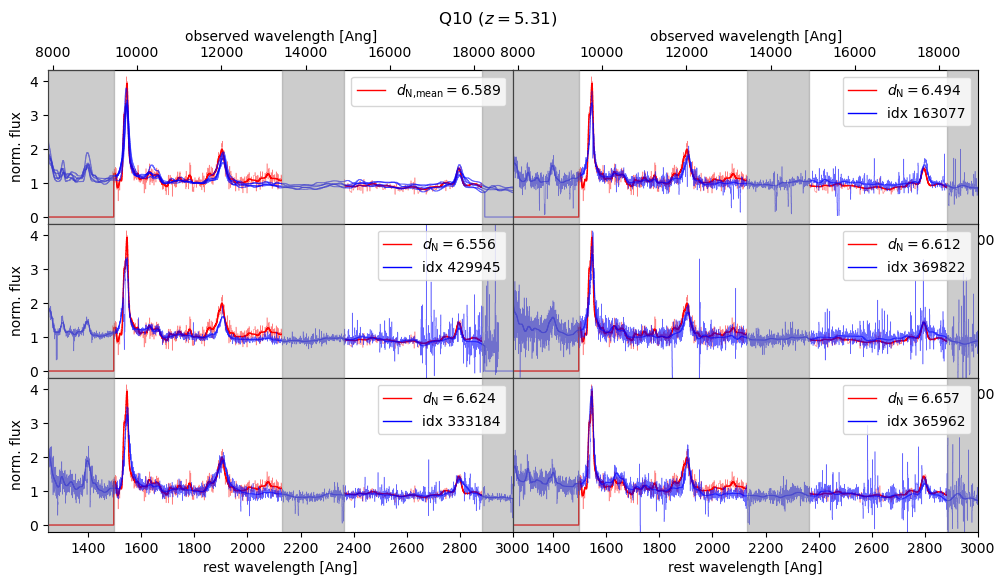

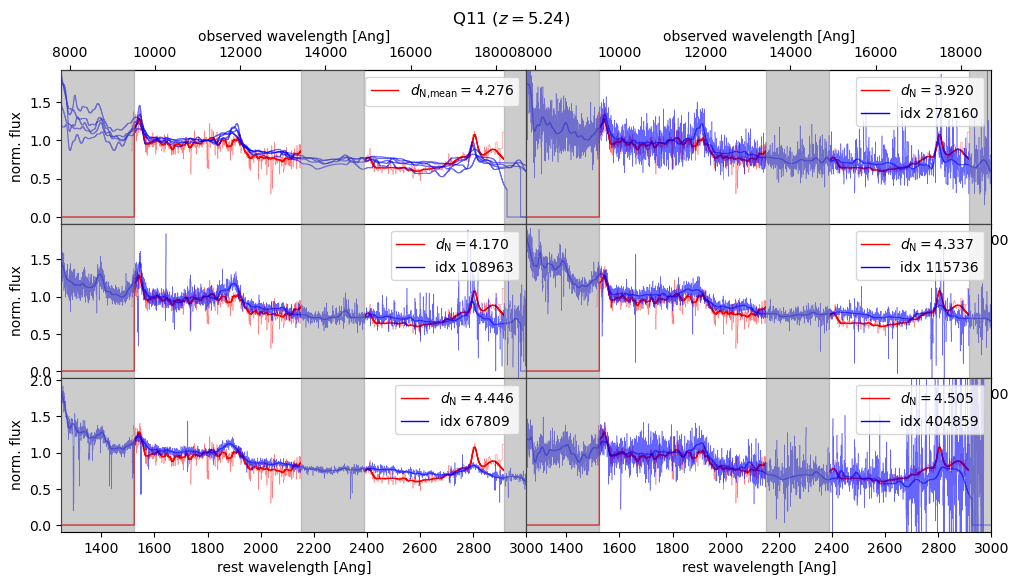

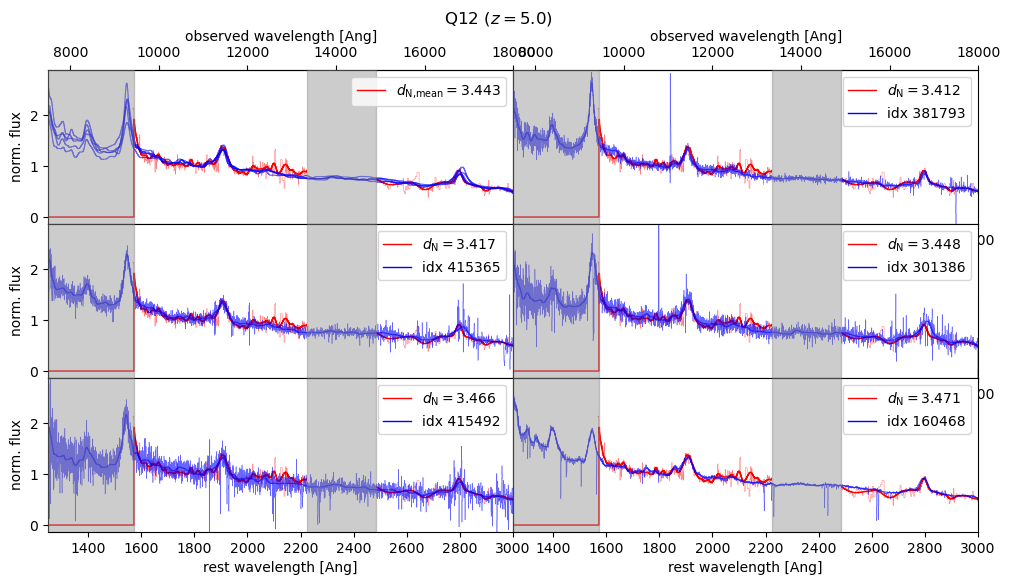

In [15]:
pp = PdfPages('plots/radio_loud_Q5_Q12_v2.pdf')
for i,qname in enumerate(qlist[:-1]):
    if i == 0:
        continue
    z = float(hZ[i])

    idx_nn, d_nn = np.array([int(id) for id in IDX_NN[i]]), np.array([float(d) for d in D_NN[i]])
    #idx_nn, d_nn = np.array([int(id) for id in IDX_NN]), np.array([float(d) for d in D_NN])
    dmean = np.mean(d_nn)

    ymax = []
    fig = plt.figure(2)
    fig.set_figwidth(12)
    fig.set_figheight(6)
    fig.suptitle(qname + ' ($z={}$)'.format(z))
    gs = gridspec.GridSpec(3, 2)

    # Create subplots within the gridspec
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1], sharex=ax1,sharey=ax1)
    ax3 = plt.subplot(gs[2], sharex=ax1)
    ax4 = plt.subplot(gs[3], sharex=ax1,sharey=ax3)
    ax5 = plt.subplot(gs[4], sharex=ax1)
    ax6 = plt.subplot(gs[5], sharex=ax1,sharey=ax5)
    ax = [ax1,ax2,ax3,ax4,ax5,ax6]

    # Plot data on each subplot
    try:
        plot_xdata(qname,fig,ax1,'red',0.4,3)
    except Exception as error:            
        err = type(error).__name__
        print('{} not plotted:'.format(qname), err) 
        plt.close()
        continue
        
    ymax.append(plot_xfit(qname,z,fig,ax1,'red',1,w1l_new[i],w1r_new[i]))
    for j,nn in enumerate(idx_nn):
        ymax.append(plot_fit(nn,fig,ax1,'b',0.8))

        plot_xdata(qname,fig,ax[j+1],'red',0.4,3)
        plot_xfit(qname,z,fig,ax[j+1],'red',1,w1l_new[i],w1r_new[i])
        plot_norm(nn,fig,ax[j+1],'b',0.4)
        plot_fit(nn,fig,ax[j+1],'b',0.8)

        ylimit = max(ymax)
        #ylimit=1.5
        ax[j+1].axvspan(1250,starts[i],alpha=0.4,color='grey',zorder=3)
        #ax[j+1].axvspan(1970,2210,alpha=0.4,color='grey',zorder=3)
        ax[j+1].axvspan(w1l_new[i], w1r_new[i]/(1+z), alpha=0.4, color='grey',zorder=3)
        ax[j+1].axvspan(w2l/(1+z), w2r/(1+z), alpha=0.4, color='grey',zorder=3)
        #ax[j+1].axvspan(2828,3000,alpha=0.4,color='grey',zorder=3)
        ax[j+1].set_ylim(-0.05*ylimit,1.1*ylimit)
        ax[j+1].set_xlim(1250,3000)

        ax[j+1].legend(custom_lines, [r'$d_\text{{N}}={:.3f}$'.format(d_nn[j]), 'idx {}'.format(idx_nn[j])], loc='upper right')

    ax1.axvspan(1250,starts[i],alpha=0.4,color='grey',zorder=3)
    #ax1.axvspan(1970,2210,alpha=0.4,color='grey',zorder=3)
    ax1.axvspan(w1l_new[i], w1r_new[i]/(1+z), alpha=0.4, color='grey',zorder=3)
    ax1.axvspan(w2l/(1+z), w2r/(1+z), alpha=0.4, color='grey',zorder=3)
    #ax1.axvspan(2828,3000,alpha=0.4,color='grey',zorder=3)
    ax1.legend([Line2D([0], [0], color='r', lw=1)], [r'$d_\text{{N,mean}}={:.3f}$'.format(dmean)], loc='upper right')
    
    sax1 = ax1.secondary_xaxis('top', functions=(func(z),inv(z)))
    sax1.set_xlabel('observed wavelength [Ang]')    
    sax2 = ax2.secondary_xaxis('top', functions=(func(z),inv(z)))
    sax2.set_xlabel('observed wavelength [Ang]')

    ax1.set_ylabel('norm. flux')
    ax3.set_ylabel('norm. flux')
    ax5.set_ylabel('norm. flux')
    ax5.set_xlabel('rest wavelength [Ang]')
    ax6.set_xlabel('rest wavelength [Ang]')
    
    ax2.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax4.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax6.tick_params(axis='y', which='both', left=False, labelleft=False)

    # Remove the space between subplots
    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)
    #plt.savefig('plots/radio_loud_{}.pdf'.format(qname),format='pdf')
    pp.savefig(fig)

    #plt.tight_layout()
    plt.show()
    plt.close()
    
pp.close()

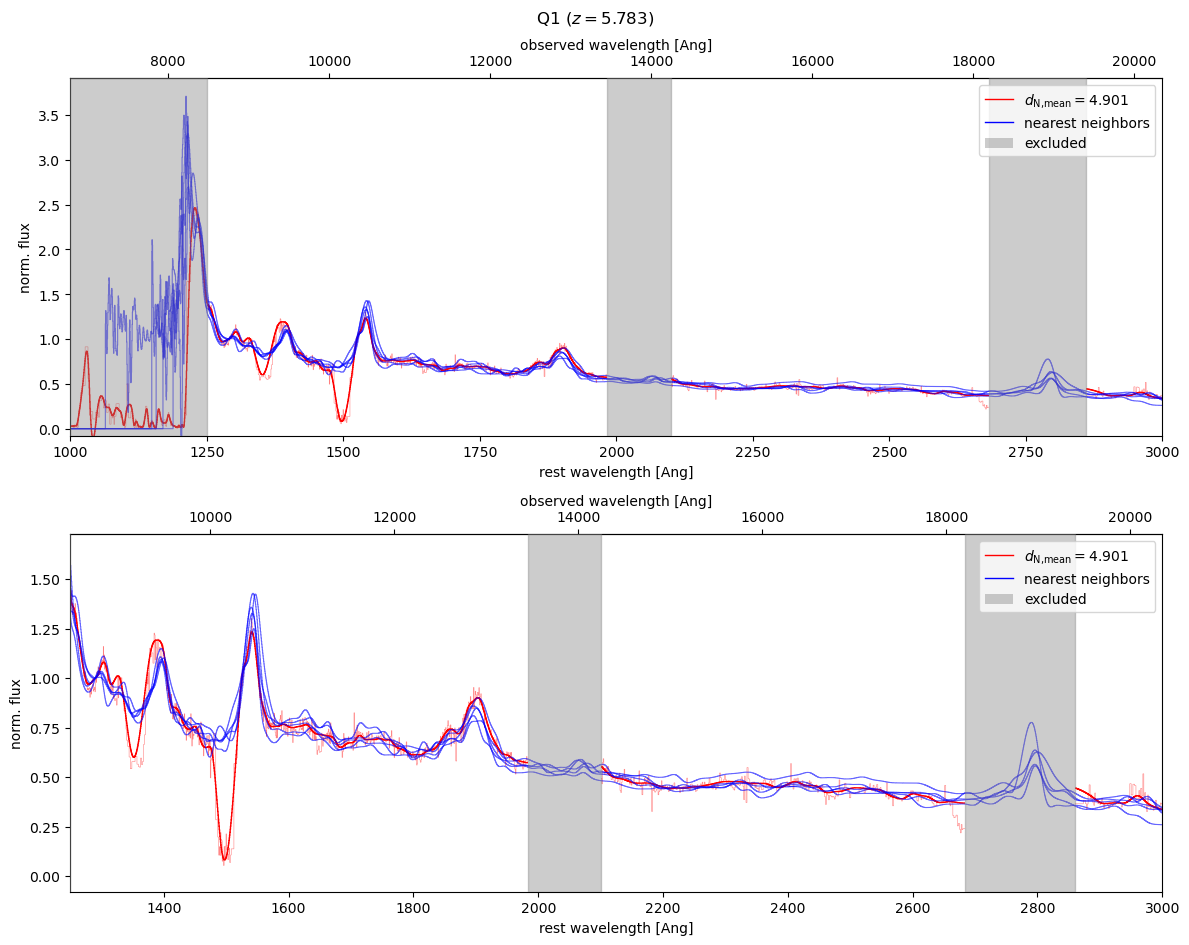

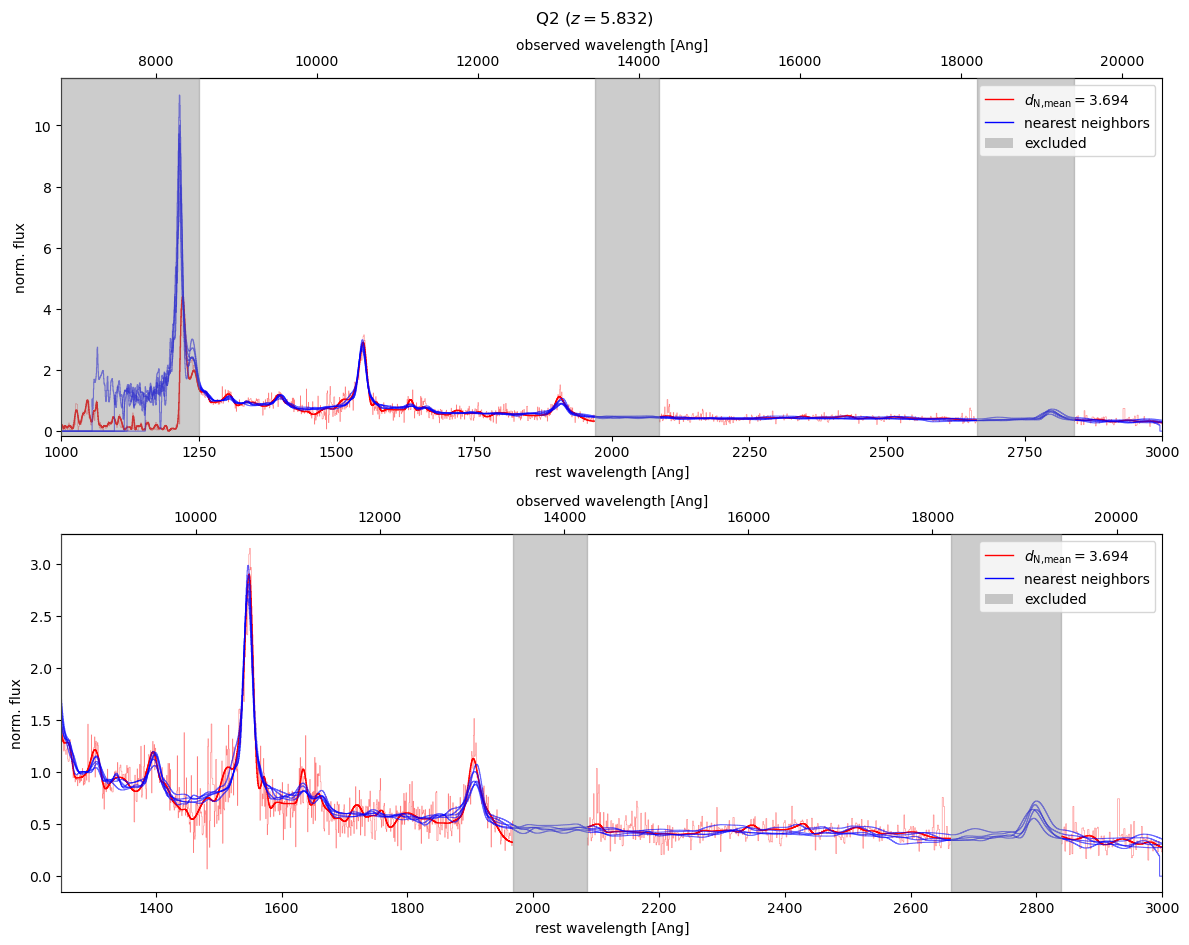

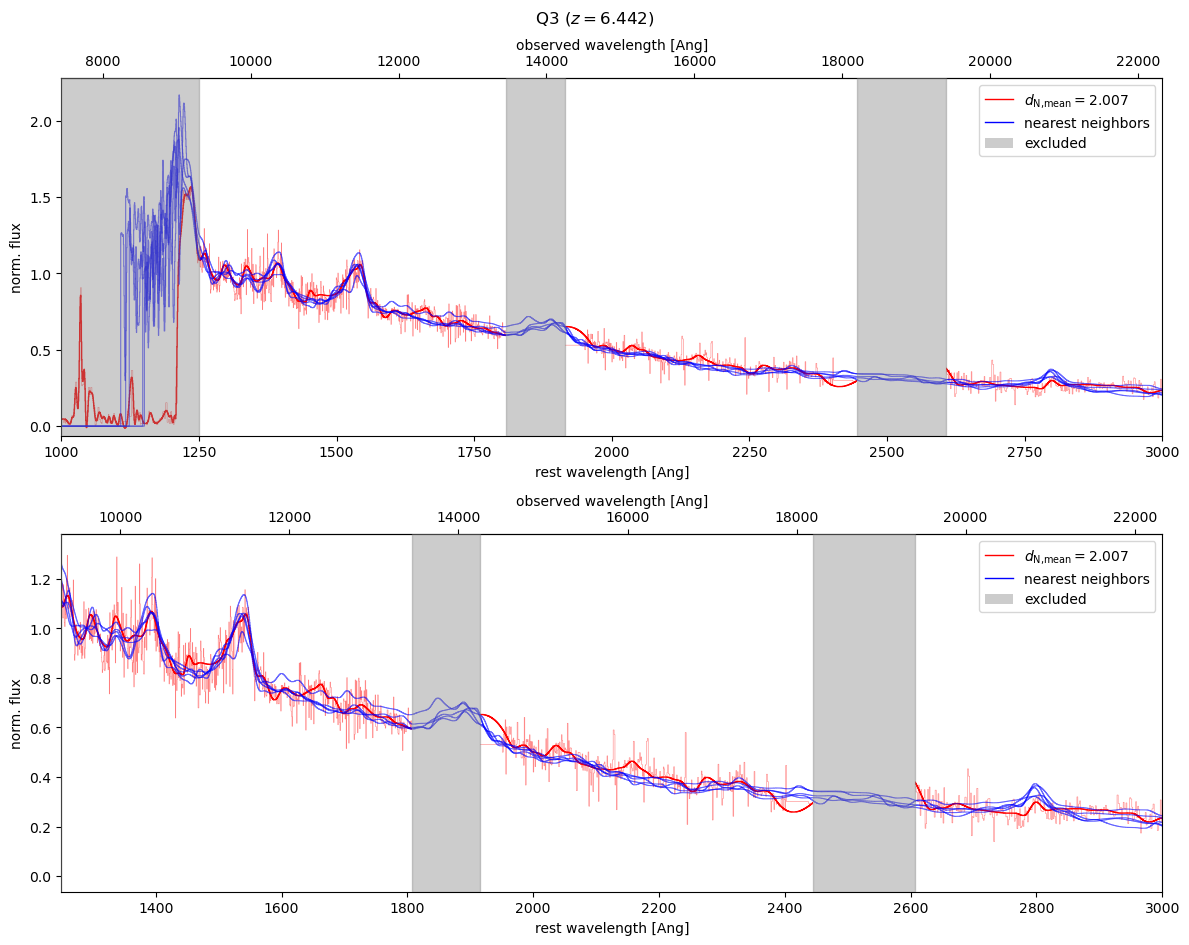

In [20]:
#pp = PdfPages('plots/radio_loud_large.pdf')
for i,qname in enumerate(qlist):
    # if qname != 'J2100-1715':
    #     continue
    z = float(hZ[i])

    idx_nn, d_nn = np.array([int(id) for id in IDX_NN[i]]), np.array([float(d) for d in D_NN[i]])
    dmean = np.mean(d_nn)

    ymax = []
    #fig, ax = plt.subplots(1)
    fig, axs = plt.subplots(2, 1)
    fig.set_figheight(9.6)
    fig.set_figwidth(12)
    fig.suptitle(qname + ' ($z={}$)'.format(z))
    for k,ax in enumerate(axs):
        try:
            plot_xdata(qname,fig,ax,'red',0.4,3)
        except Exception as error:            
            err = type(error).__name__
            print('{} not plotted:'.format(qname), err) 
            plt.close()
            continue
            
        ymax.append(plot_xfit(qname,z,fig,ax,'red',1))
    
        for j,nn in enumerate(idx_nn):
            ymax.append(plot_fit(nn,fig,ax,'b',0.8))
    
        ax.axvspan(w1l/(1+z), w1r/(1+z), alpha=0.4, color='grey',zorder=3)
        ax.axvspan(w2l/(1+z), w2r/(1+z), alpha=0.4, color='grey',zorder=3)
        ax.axvspan(1000,1250,alpha=0.4,color='grey',zorder=3)
        #ax.axvspan(2250,3000,alpha=0.4,color='grey',zorder=3)
        ylimit = max(ymax)
        ax.set_xlabel('rest wavelength [Ang]')
        ax.set_ylabel('norm. flux')
        sax = ax.secondary_xaxis('top', functions=(func(z),inv(z)))
        sax.set_xlabel('observed wavelength [Ang]')
        ax.legend(custom_lines, [r'$d_\text{{N,mean}}={:.3f}$'.format(dmean), 'nearest neighbors', 'excluded'], loc='upper right')  
    # for j, l in enumerate(elines[:-1]):
    #     axs[0].axvline(l,c='black',ls='--',lw=0.7)
    #     axs[0].text(l+6,axs[0].get_ylim()[1]*0.973,enames[j],c='black',rotation='vertical',va='top',size='small')
    # axs[0].axvline(elines[-1],c='black',ls='--',lw=0.7)
    # axs[0].text(elines[-1]+6,axs[0].get_ylim()[1]*0.75,enames[-1],c='black',rotation='vertical',va='top',size='small')    
    # for j, l in enumerate(elines[3:-3]):
    #     axs[1].axvline(l,c='black',ls='--',lw=0.7)
    #     axs[1].text(l+3,1.07*ylimit,enames[3:-3][j],c='black',rotation='vertical',va='top',size='small')
    axs[0].set_ylim(-0.05*ylimit,None)
    axs[1].set_ylim(-0.05*ylimit,1.1*ylimit)
    axs[0].set_xlim(1000,3000)
    axs[1].set_xlim(1250,3000)
    plt.tight_layout()
    #pp.savefig(fig)
    #plt.savefig('plots/{}_nn.png'.format(qname),format='png')
    plt.show()
    plt.close()
#pp.close()

In [17]:
%matplotlib inline
from specdb.specdb import SpecDB, IgmSpec

igmsp = SpecDB('/media/bartosz/USB STICK/BOSS_DR14/IGMspec_DB_v03.1.hdf5')
meta = igmsp['BOSS_DR14'].meta

Database is igmspec
Created on 2019-Mar-06
Version: v03.1


In [28]:
NN_file = np.loadtxt('/media/bartosz/USB STICK/added_sample_XIE/rl_NN_full_sc_v2.txt', dtype='str')

NAMES = ['Q4','Q5','Q6','Q7','Q8','Q9','Q10','Q11','Q12','Q13']

for j, n in enumerate(NAMES):
        
    qlist = NN_file[:,1:51][j]
    ndist = NN_file[:,51:][j]
    for i,q in enumerate(qlist):
        nnid = int(q)
        ra, dec = meta[nnid][0], meta[nnid][1]
        #print('{}-{}'.format(n,nnid))
        print(ra)
        #print(dec)
        #print(ndist[i])

154.04622866423682
248.76420397661133
351.04805471472605
205.5546067888198
209.8749841168234
355.42517049086166
174.11843539421943
141.23294174631204
252.26368246944813
216.73810917799858
202.5744782198788
173.33435097017585
172.27045192563094
217.278026886336
134.4796041330959
130.10319262407128
128.96559799924762
223.644581526291
174.38420292222142
162.38998058704726
154.74611590255842
201.79923036192082
236.1810377937024
200.6480954769682
183.99423887856472
12.175107102181528
14.46297074489928
221.07018587520284
14.739787148081861
206.9370000763289
129.12723229659608
146.9502856190333
129.84867023086372
23.120408453717342
185.60957433128917
214.05065347115985
183.36244286555404
239.5390336144672
208.38029110293078
348.5275344085618
187.46879946965728
40.697681498257616
230.89742832457463
221.34938838807471
0.03908584727383868
225.35275022198533
236.26349770213287
230.6365035084733
239.17722769400746
36.63546792622029
2.9870948637648667
236.6344591731101
213.56421981111737
349.291199